# Time Series Analysis: Porto Weather & Air Quality
## Complete Analysis - Hourly and Daily Data

**Objective:** Analyze and forecast temperature (weather) and PM2.5 (air quality) time series for Porto, Portugal

**Data Source:** Open-Meteo API (Historical Weather & Air Quality)
- Period: Last 5 years
- Location: Porto, Portugal (41.1496°N, 8.6109°W)
- Frequency: Hourly (43,824 observations) and Daily (aggregated)

**Variables of Interest:**
- Temperature (temperature_2m) - in °C
- PM2.5 (pm2_5) - in μg/m³

## 0. Setup and Imports

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.precision', 4)

print("✓ Libraries imported successfully!")
print(f"  pandas version: {pd.__version__}")
print(f"  numpy version: {np.__version__}")

✓ Libraries imported successfully!
  pandas version: 2.3.2
  numpy version: 2.3.3


## 1. Load and Prepare Data

In [4]:
# Load the dataset
df = pd.read_csv('porto_weather_air_quality_5y.csv')

# Convert time to datetime and set as index
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

print("Dataset loaded successfully!")
print(f"  Shape: {df.shape}")
print(f"  Date range: {df.index.min()} to {df.index.max()}")
print(f"  Duration: {(df.index.max() - df.index.min()).days} days")
print(f"\nFirst few rows:")
df.head()

Dataset loaded successfully!
  Shape: (43824, 30)
  Date range: 2020-12-06 00:00:00 to 2025-12-05 23:00:00
  Duration: 1825 days

First few rows:


,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,pressure_msl,surface_pressure,precipitation,rain,snowfall,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_80m,winddirection_10m,winddirection_80m,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,sulphur_dioxide,ozone,aerosol_optical_depth,dust,uv_index,uv_index_clear_sky
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-06 00:00:00,7.3,84,4.8,4.3,1014.8,1003.5,0.0,0.0,0.0,58,28,47,0,0.0,0.0,0.0,12.0,NaN,351,NaN,22.1,9.0,146.0,15.2,1.3,32.0,NaN,0.0,NaN,NaN
2020-12-06 01:00:00,7.0,87,5.0,4.4,1014.6,1003.3,0.0,0.0,0.0,66,55,46,0,0.0,0.0,0.0,9.4,NaN,356,NaN,18.5,9.6,144.0,15.2,1.4,34.0,NaN,0.0,NaN,NaN
2020-12-06 02:00:00,6.4,90,4.9,4.3,1014.3,1003.0,0.0,0.0,0.0,45,16,40,0,0.0,0.0,0.0,6.1,NaN,360,NaN,20.9,10.5,142.0,14.7,1.2,35.0,NaN,0.0,NaN,NaN
2020-12-06 03:00:00,6.7,89,5.1,4.6,1014.6,1003.3,0.1,0.1,0.0,51,31,38,10,0.0,0.0,0.0,6.5,NaN,357,NaN,24.3,10.9,140.0,14.0,1.3,27.0,NaN,0.0,NaN,NaN
2020-12-06 04:00:00,7.0,88,5.2,4.8,1014.6,1003.3,0.2,0.2,0.0,53,42,45,0,0.0,0.0,0.0,6.5,NaN,19,NaN,24.7,10.8,143.0,16.0,1.2,32.0,NaN,0.0,NaN,NaN


In [5]:
# Check for missing values in our target variables
print("Missing Values Check:")
print(f"  temperature_2m: {df['temperature_2m'].isnull().sum()} ({df['temperature_2m'].isnull().sum()/len(df)*100:.2f}%)")
print(f"  pm2_5: {df['pm2_5'].isnull().sum()} ({df['pm2_5'].isnull().sum()/len(df)*100:.2f}%)")

# Basic statistics
print("\nBasic Statistics:")
df[['temperature_2m', 'pm2_5']].describe()

Missing Values Check:
  temperature_2m: 0 (0.00%)
  pm2_5: 0 (0.00%)

Basic Statistics:


,temperature_2m,pm2_5
count,43824.0000,43824.0000
mean,15.3648,11.8370
std,4.8629,8.0521
min,-0.2000,1.5000
25%,12.1000,6.7000
50%,15.3000,9.3000
75%,18.4000,14.2000
max,36.2000,96.8000


## 2. Extract and Prepare Target Variables

We'll create both **hourly** and **daily** versions of our target variables

In [6]:
# Extract HOURLY data (original frequency)
temp_hourly = df['temperature_2m'].copy()
pm25_hourly = df['pm2_5'].copy()

# Handle missing values for hourly data (interpolate)
if temp_hourly.isnull().any():
    print(f"Interpolating {temp_hourly.isnull().sum()} missing temperature values...")
    temp_hourly = temp_hourly.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

if pm25_hourly.isnull().any():
    print(f"Interpolating {pm25_hourly.isnull().sum()} missing PM2.5 values...")
    pm25_hourly = pm25_hourly.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

print(f"\n✓ HOURLY DATA:")
print(f"  Temperature: {len(temp_hourly)} observations")
print(f"  PM2.5: {len(pm25_hourly)} observations")
print(f"  Frequency: Hourly (24 observations per day)")
print(f"  Duration: {len(temp_hourly)/(24*365):.2f} years")


✓ HOURLY DATA:
  Temperature: 43824 observations
  PM2.5: 43824 observations
  Frequency: Hourly (24 observations per day)
  Duration: 5.00 years


In [7]:
# Create DAILY data (resample and aggregate)
temp_daily = temp_hourly.resample('D').mean()
pm25_daily = pm25_hourly.resample('D').mean()

print(f"✓ DAILY DATA:")
print(f"  Temperature: {len(temp_daily)} observations")
print(f"  PM2.5: {len(pm25_daily)} observations")
print(f"  Frequency: Daily (1 observation per day)")
print(f"  Duration: {len(temp_daily)/365:.2f} years")

✓ DAILY DATA:
  Temperature: 1826 observations
  PM2.5: 1826 observations
  Frequency: Daily (1 observation per day)
  Duration: 5.00 years


In [8]:
# Summary statistics comparison
print("="*70)
print("TEMPERATURE STATISTICS COMPARISON")
print("="*70)

stats_temp = pd.DataFrame({
    'Hourly': temp_hourly.describe(),
    'Daily': temp_daily.describe()
})
print(stats_temp)

print("\n" + "="*70)
print("PM2.5 STATISTICS COMPARISON")
print("="*70)

stats_pm25 = pd.DataFrame({
    'Hourly': pm25_hourly.describe(),
    'Daily': pm25_daily.describe()
})
print(stats_pm25)

TEMPERATURE STATISTICS COMPARISON
           Hourly      Daily
count  43824.0000  1826.0000
mean      15.3648    15.3648
std        4.8629     4.1927
min       -0.2000     3.6708
25%       12.1000    12.2979
50%       15.3000    15.4167
75%       18.4000    18.4958
max       36.2000    31.0083

PM2.5 STATISTICS COMPARISON
           Hourly      Daily
count  43824.0000  1826.0000
mean      11.8370    11.8370
std        8.0521     6.3884
min        1.5000     2.7375
25%        6.7000     7.4115
50%        9.3000     9.9792
75%       14.2000    14.5500
max       96.8000    46.9708


## 3. Visual Exploration: Time Series Plots

### 3.1 Complete Time Series (5 Years)

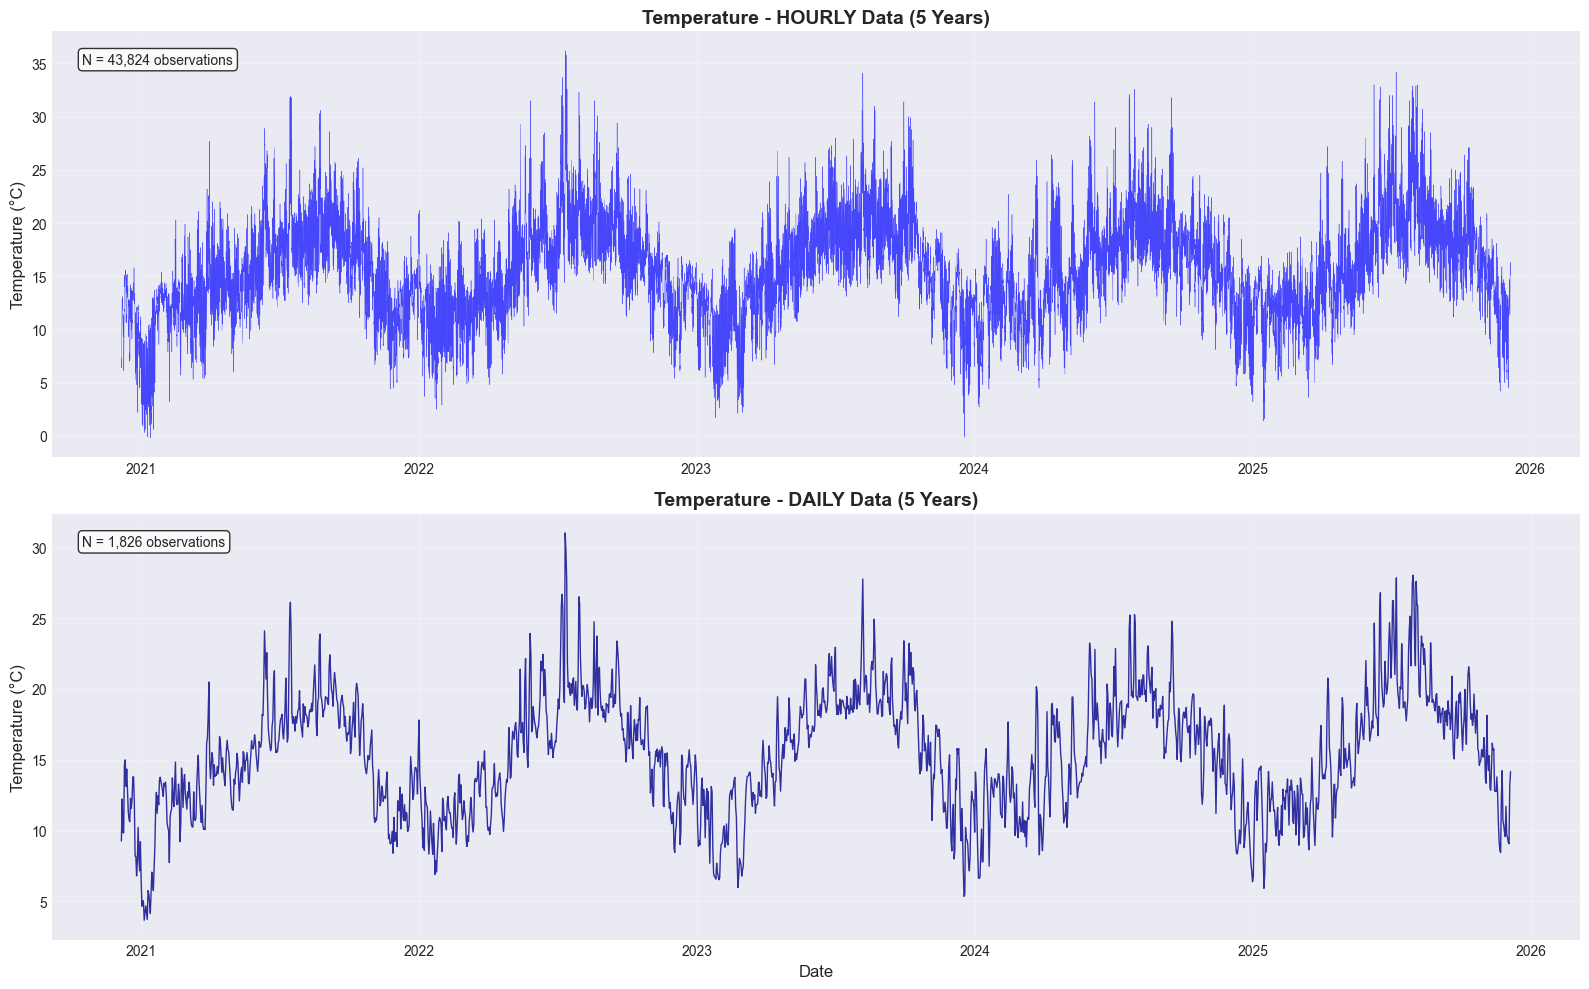

In [9]:
# Temperature - Full time series comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Hourly
axes[0].plot(temp_hourly.index, temp_hourly.values, linewidth=0.3, alpha=0.7, color='blue')
axes[0].set_title('Temperature - HOURLY Data (5 Years)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'N = {len(temp_hourly):,} observations', 
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Daily
axes[1].plot(temp_daily.index, temp_daily.values, linewidth=1, alpha=0.8, color='darkblue')
axes[1].set_title('Temperature - DAILY Data (5 Years)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Temperature (°C)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f'N = {len(temp_daily):,} observations', 
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

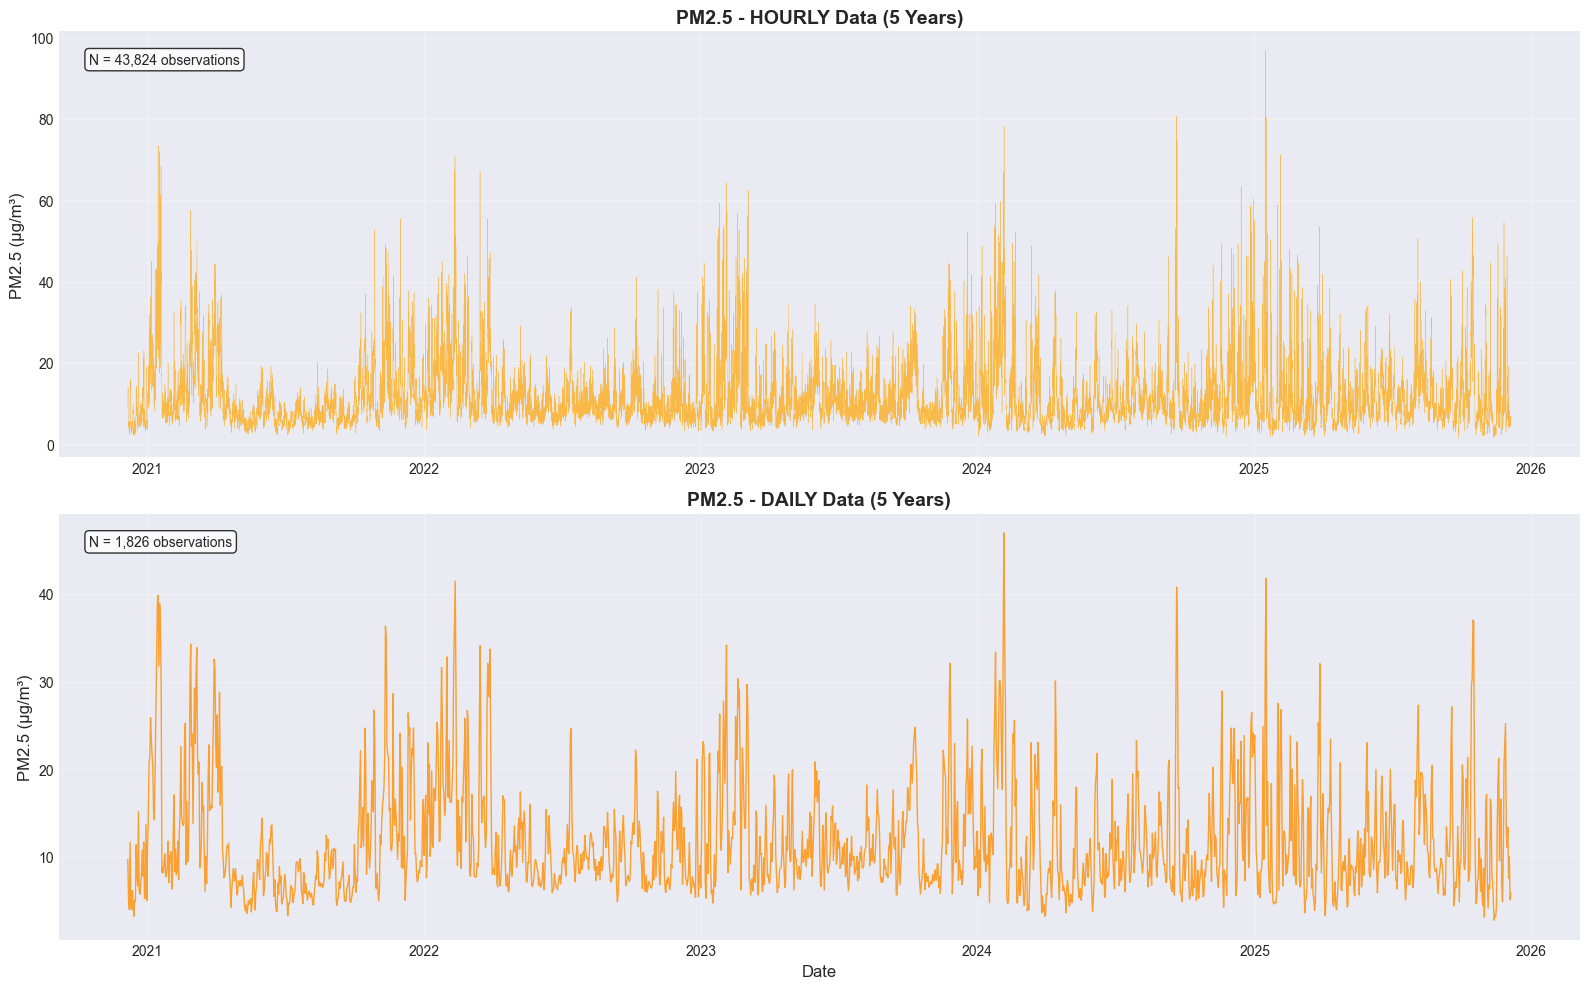

In [10]:
# PM2.5 - Full time series comparison
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Hourly
axes[0].plot(pm25_hourly.index, pm25_hourly.values, linewidth=0.3, alpha=0.7, color='orange')
axes[0].set_title('PM2.5 - HOURLY Data (5 Years)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'N = {len(pm25_hourly):,} observations', 
             transform=axes[0].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Daily
axes[1].plot(pm25_daily.index, pm25_daily.values, linewidth=1, alpha=0.8, color='darkorange')
axes[1].set_title('PM2.5 - DAILY Data (5 Years)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f'N = {len(pm25_daily):,} observations', 
             transform=axes[1].transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### 3.2 Zoom: One Year View

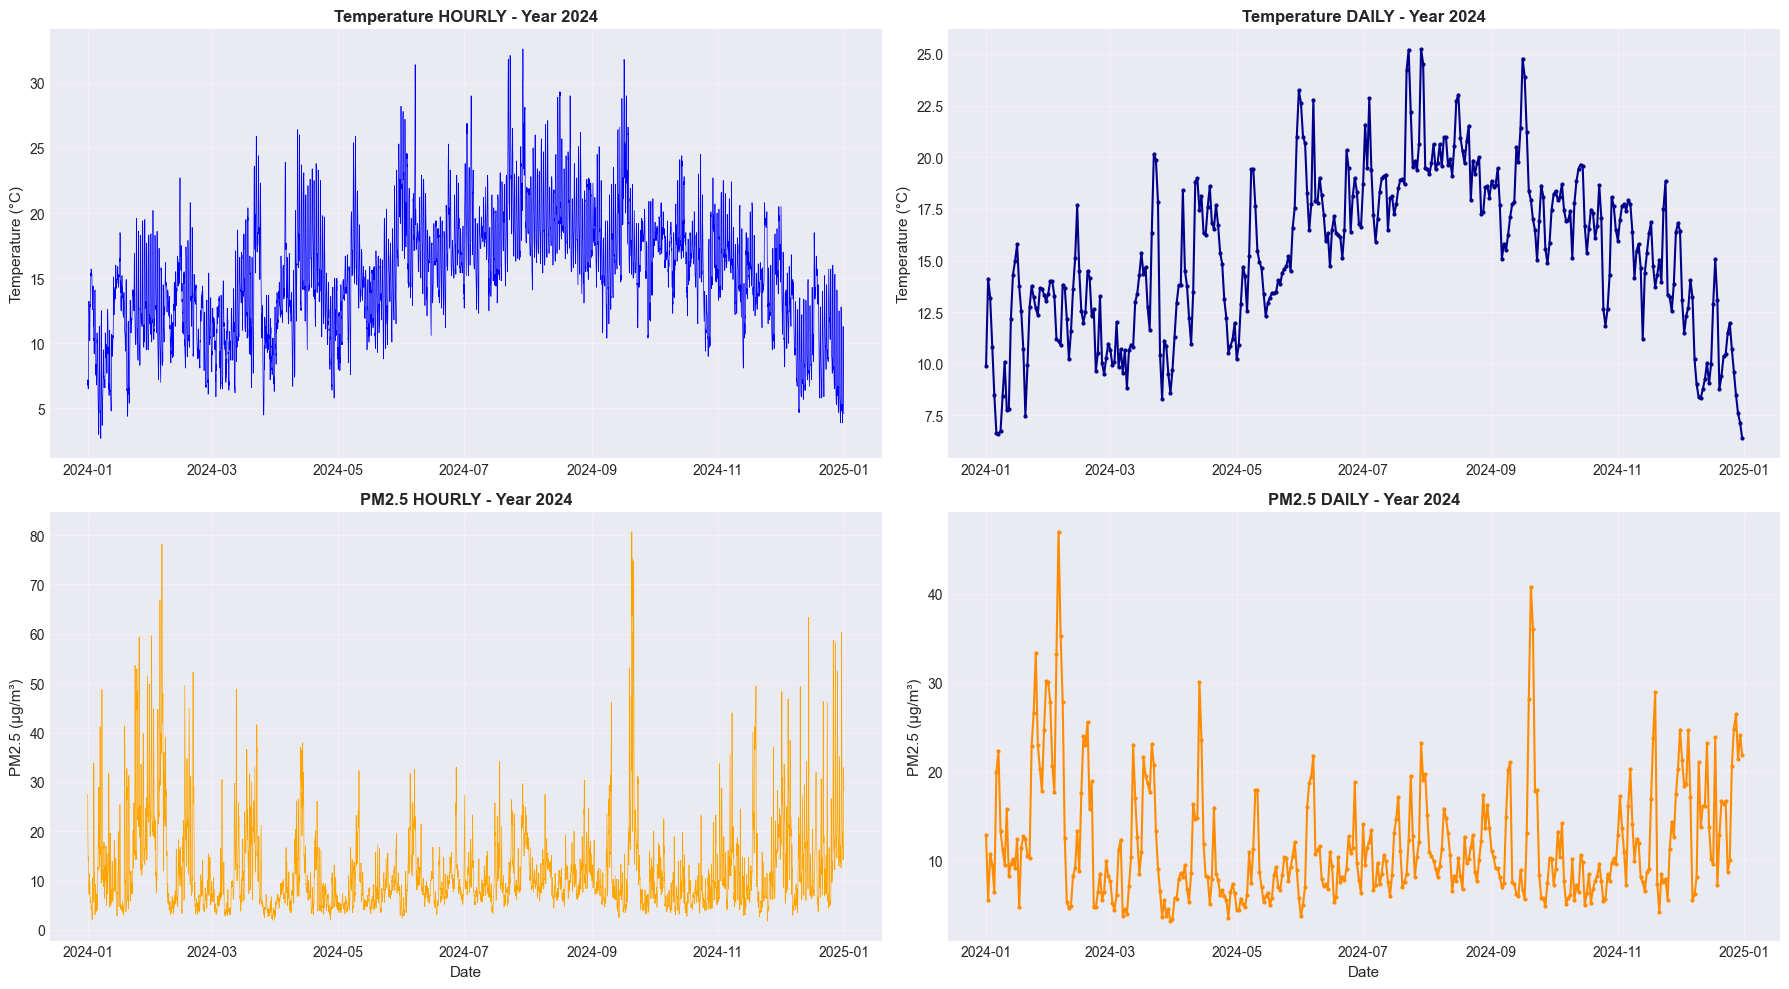

In [11]:
# Select a year to zoom in
year = '2024'

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Temperature - Hourly (year)
temp_h_year = temp_hourly[year]
axes[0, 0].plot(temp_h_year.index, temp_h_year.values, linewidth=0.5, color='blue')
axes[0, 0].set_title(f'Temperature HOURLY - Year {year}', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Temperature - Daily (year)
temp_d_year = temp_daily[year]
axes[0, 1].plot(temp_d_year.index, temp_d_year.values, linewidth=1.5, marker='o', markersize=2, color='darkblue')
axes[0, 1].set_title(f'Temperature DAILY - Year {year}', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# PM2.5 - Hourly (year)
pm25_h_year = pm25_hourly[year]
axes[1, 0].plot(pm25_h_year.index, pm25_h_year.values, linewidth=0.5, color='orange')
axes[1, 0].set_title(f'PM2.5 HOURLY - Year {year}', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# PM2.5 - Daily (year)
pm25_d_year = pm25_daily[year]
axes[1, 1].plot(pm25_d_year.index, pm25_d_year.values, linewidth=1.5, marker='o', markersize=2, color='darkorange')
axes[1, 1].set_title(f'PM2.5 DAILY - Year {year}', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 1].set_xlabel('Date', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.3 Zoom: One Week View (Shows Daily Cycles)

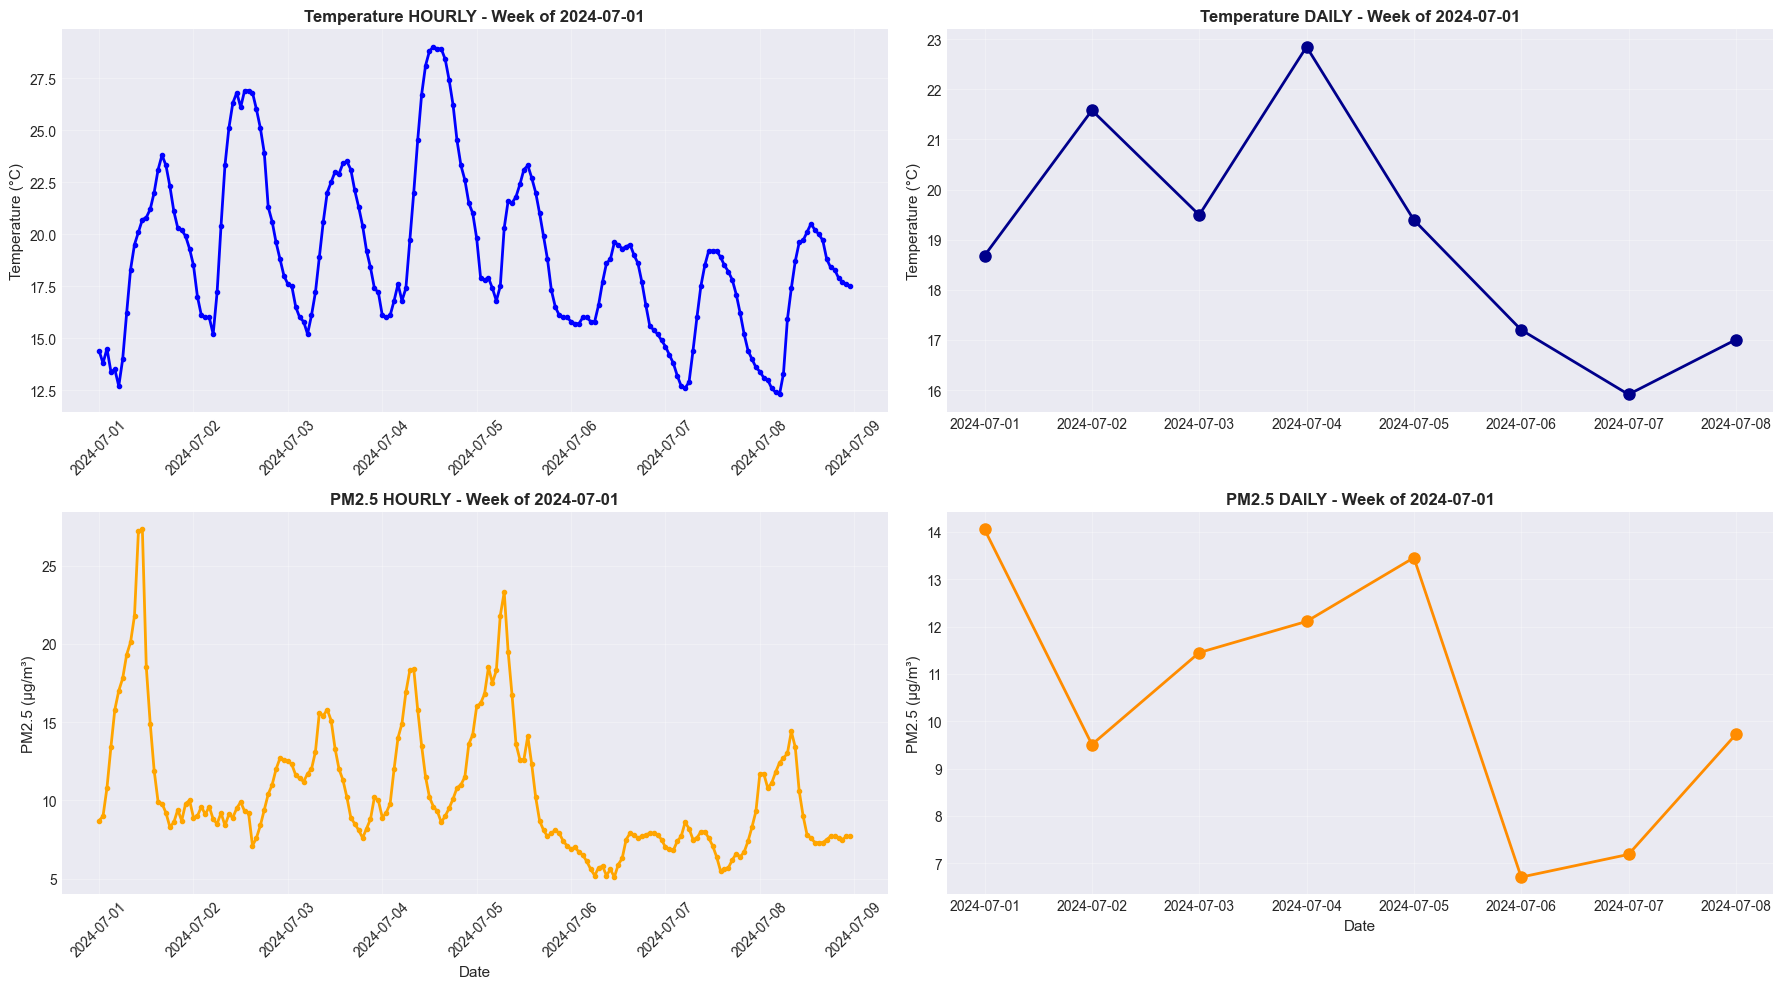

In [35]:
# Select a week in summer to see clear daily patterns
week_start = '2024-07-01'
week_end = '2024-07-08'

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Temperature - Hourly (week)
temp_h_week = temp_hourly[week_start:week_end]
axes[0, 0].plot(temp_h_week.index, temp_h_week.values, linewidth=2, marker='o', markersize=3, color='blue')
axes[0, 0].set_title(f'Temperature HOURLY - Week of {week_start}', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Temperature - Daily (week)
temp_d_week = temp_daily[week_start:week_end]
axes[0, 1].plot(temp_d_week.index, temp_d_week.values, linewidth=2, marker='o', markersize=8, color='darkblue')
axes[0, 1].set_title(f'Temperature DAILY - Week of {week_start}', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# PM2.5 - Hourly (week)
pm25_h_week = pm25_hourly[week_start:week_end]
axes[1, 0].plot(pm25_h_week.index, pm25_h_week.values, linewidth=2, marker='o', markersize=3, color='orange')
axes[1, 0].set_title(f'PM2.5 HOURLY - Week of {week_start}', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# PM2.5 - Daily (week)
pm25_d_week = pm25_daily[week_start:week_end]
axes[1, 1].plot(pm25_d_week.index, pm25_d_week.values, linewidth=2, marker='o', markersize=8, color='darkorange')
axes[1, 1].set_title(f'PM2.5 DAILY - Week of {week_start}', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 1].set_xlabel('Date', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 4. Distribution Analysis

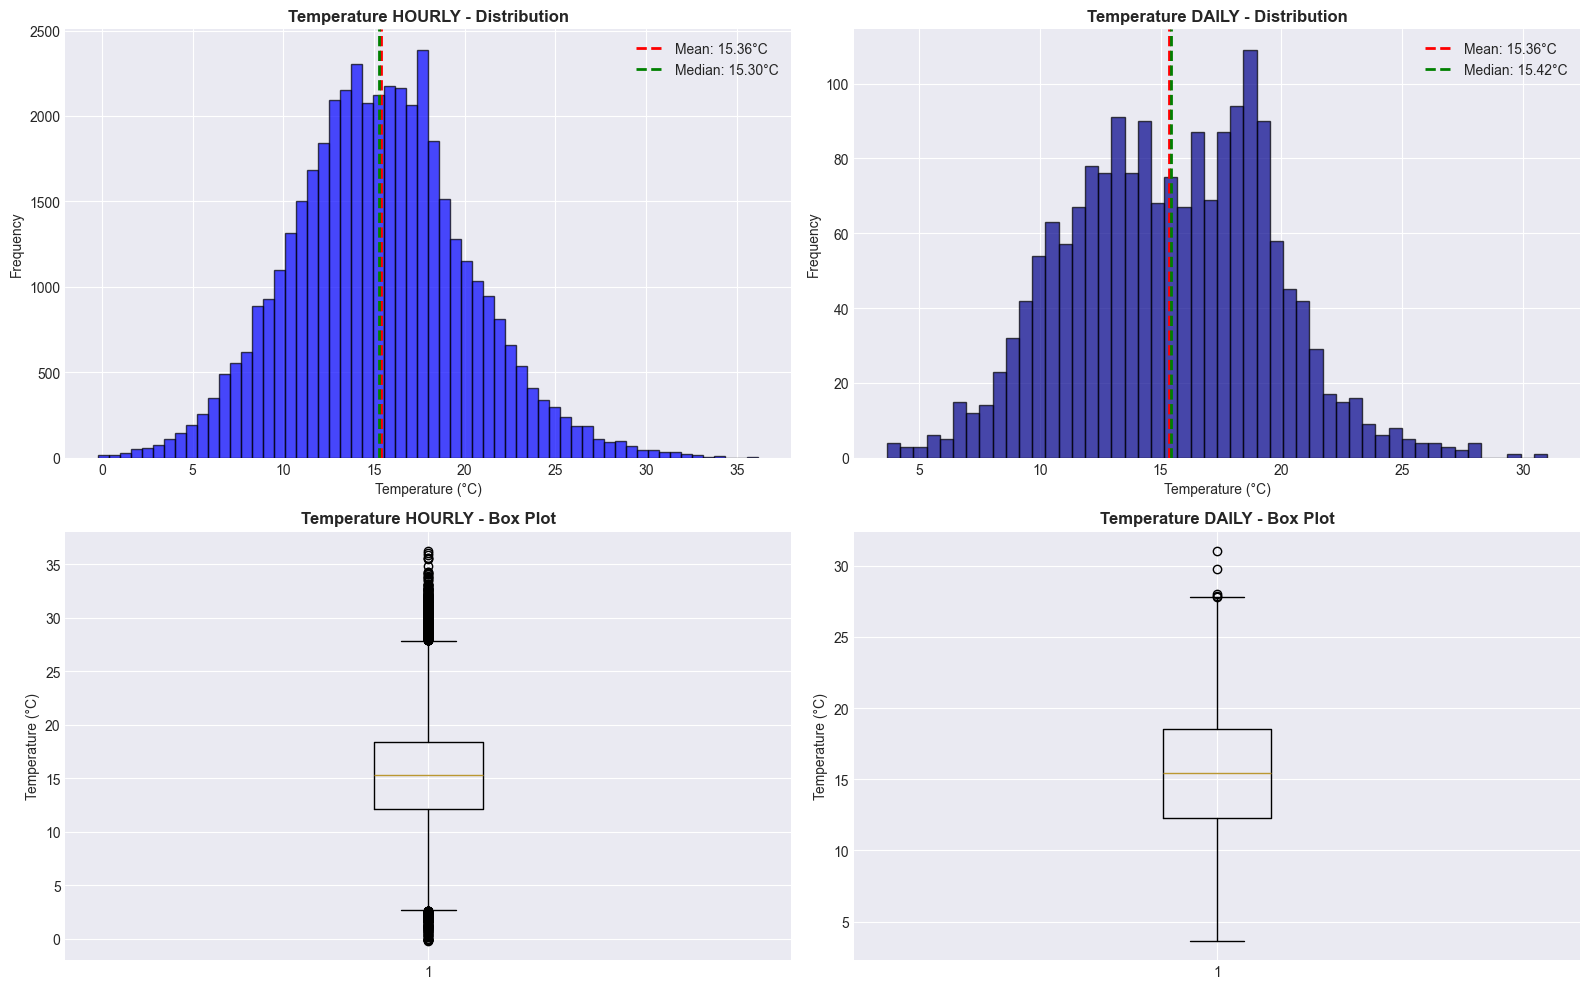

In [13]:
# Distribution plots - Temperature
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Hourly - Histogram
axes[0, 0].hist(temp_hourly.values, bins=60, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].axvline(temp_hourly.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {temp_hourly.mean():.2f}°C')
axes[0, 0].axvline(temp_hourly.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {temp_hourly.median():.2f}°C')
axes[0, 0].set_title('Temperature HOURLY - Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Daily - Histogram
axes[0, 1].hist(temp_daily.values, bins=50, edgecolor='black', alpha=0.7, color='darkblue')
axes[0, 1].axvline(temp_daily.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {temp_daily.mean():.2f}°C')
axes[0, 1].axvline(temp_daily.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {temp_daily.median():.2f}°C')
axes[0, 1].set_title('Temperature DAILY - Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Hourly - Boxplot
axes[1, 0].boxplot(temp_hourly.values, vert=True)
axes[1, 0].set_title('Temperature HOURLY - Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Temperature (°C)')

# Daily - Boxplot
axes[1, 1].boxplot(temp_daily.values, vert=True)
axes[1, 1].set_title('Temperature DAILY - Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

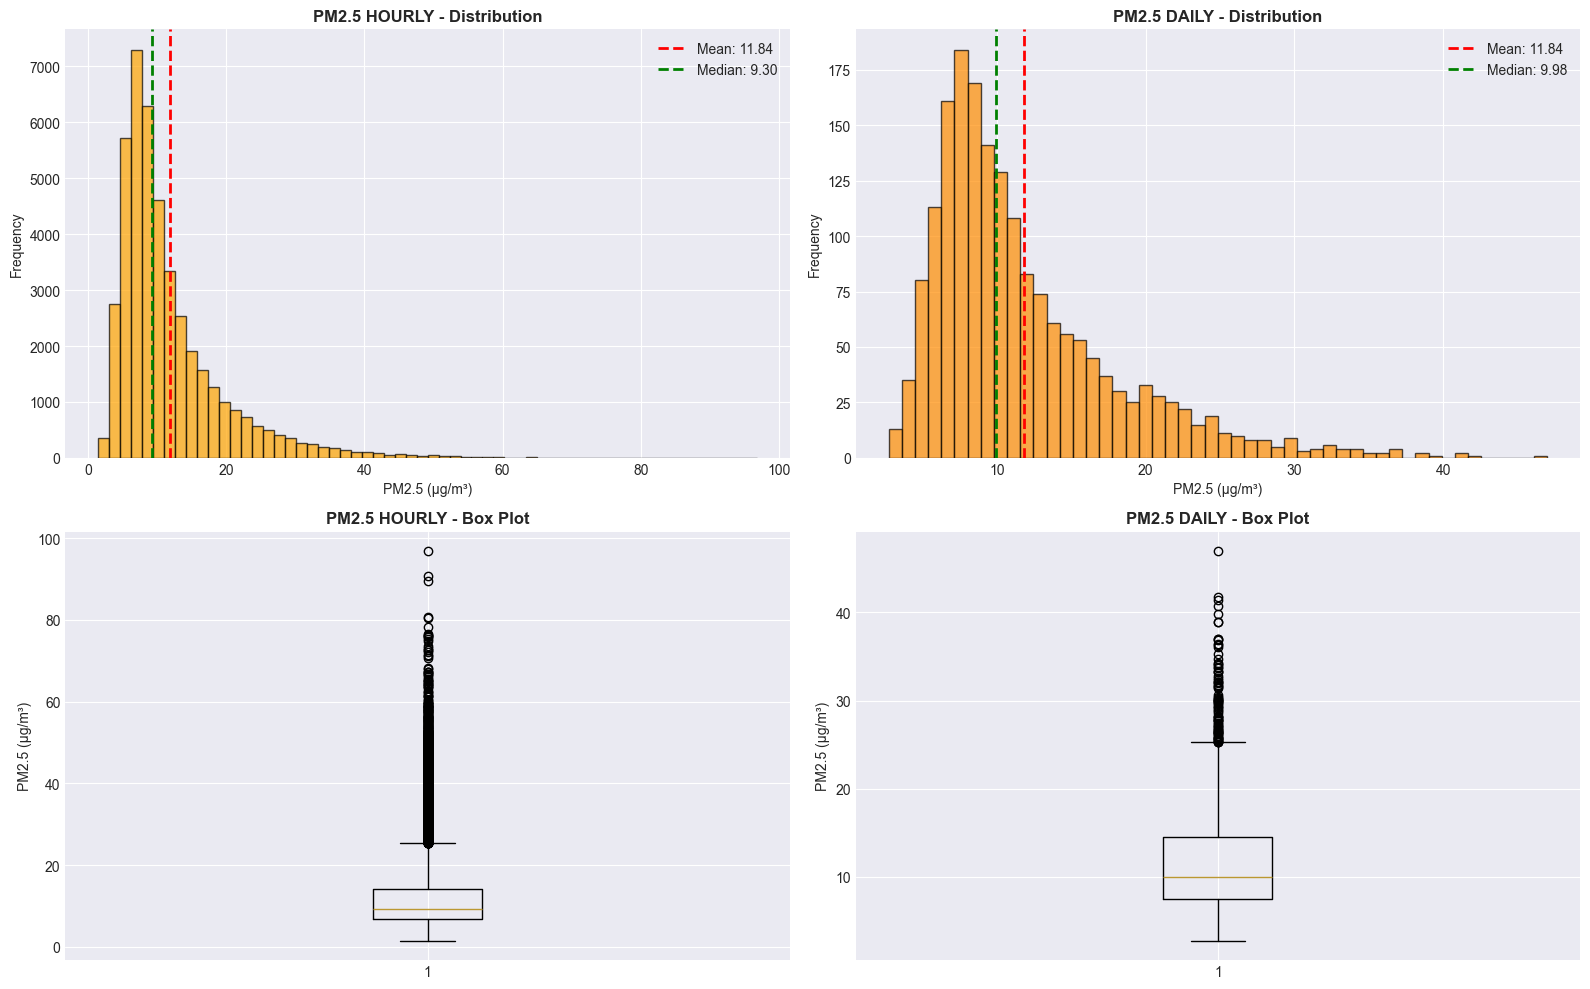

In [14]:
# Distribution plots - PM2.5
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Hourly - Histogram
axes[0, 0].hist(pm25_hourly.values, bins=60, edgecolor='black', alpha=0.7, color='orange')
axes[0, 0].axvline(pm25_hourly.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {pm25_hourly.mean():.2f}')
axes[0, 0].axvline(pm25_hourly.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {pm25_hourly.median():.2f}')
axes[0, 0].set_title('PM2.5 HOURLY - Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('PM2.5 (μg/m³)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Daily - Histogram
axes[0, 1].hist(pm25_daily.values, bins=50, edgecolor='black', alpha=0.7, color='darkorange')
axes[0, 1].axvline(pm25_daily.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {pm25_daily.mean():.2f}')
axes[0, 1].axvline(pm25_daily.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {pm25_daily.median():.2f}')
axes[0, 1].set_title('PM2.5 DAILY - Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('PM2.5 (μg/m³)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Hourly - Boxplot
axes[1, 0].boxplot(pm25_hourly.values, vert=True)
axes[1, 0].set_title('PM2.5 HOURLY - Box Plot', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)')

# Daily - Boxplot
axes[1, 1].boxplot(pm25_daily.values, vert=True)
axes[1, 1].set_title('PM2.5 DAILY - Box Plot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('PM2.5 (μg/m³)')

plt.tight_layout()
plt.show()

In [15]:
# Skewness and Kurtosis
print("="*70)
print("DISTRIBUTION STATISTICS")
print("="*70)

print("\nTEMPERATURE:")
print(f"  Hourly  - Skewness: {stats.skew(temp_hourly.values):>7.4f}  |  Kurtosis: {stats.kurtosis(temp_hourly.values):>7.4f}")
print(f"  Daily   - Skewness: {stats.skew(temp_daily.values):>7.4f}  |  Kurtosis: {stats.kurtosis(temp_daily.values):>7.4f}")

print("\nPM2.5:")
print(f"  Hourly  - Skewness: {stats.skew(pm25_hourly.values):>7.4f}  |  Kurtosis: {stats.kurtosis(pm25_hourly.values):>7.4f}")
print(f"  Daily   - Skewness: {stats.skew(pm25_daily.values):>7.4f}  |  Kurtosis: {stats.kurtosis(pm25_daily.values):>7.4f}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("  Skewness ≈ 0: Symmetric distribution")
print("  Skewness > 0: Right-skewed (long tail on right)")
print("  Skewness < 0: Left-skewed (long tail on left)")
print("  Kurtosis ≈ 0: Normal-like tails")
print("  Kurtosis > 0: Heavy tails (more outliers)")
print("  Kurtosis < 0: Light tails (fewer outliers)")
print("="*70)

DISTRIBUTION STATISTICS

TEMPERATURE:
  Hourly  - Skewness:  0.2070  |  Kurtosis:  0.2964
  Daily   - Skewness:  0.0686  |  Kurtosis: -0.1572

PM2.5:
  Hourly  - Skewness:  2.3006  |  Kurtosis:  7.8230
  Daily   - Skewness:  1.5711  |  Kurtosis:  2.8883

INTERPRETATION:
  Skewness ≈ 0: Symmetric distribution
  Skewness > 0: Right-skewed (long tail on right)
  Skewness < 0: Left-skewed (long tail on left)
  Kurtosis ≈ 0: Normal-like tails
  Kurtosis > 0: Heavy tails (more outliers)
  Kurtosis < 0: Light tails (fewer outliers)


## 5. Seasonal Patterns

### 5.1 Monthly Patterns (Yearly Seasonality)

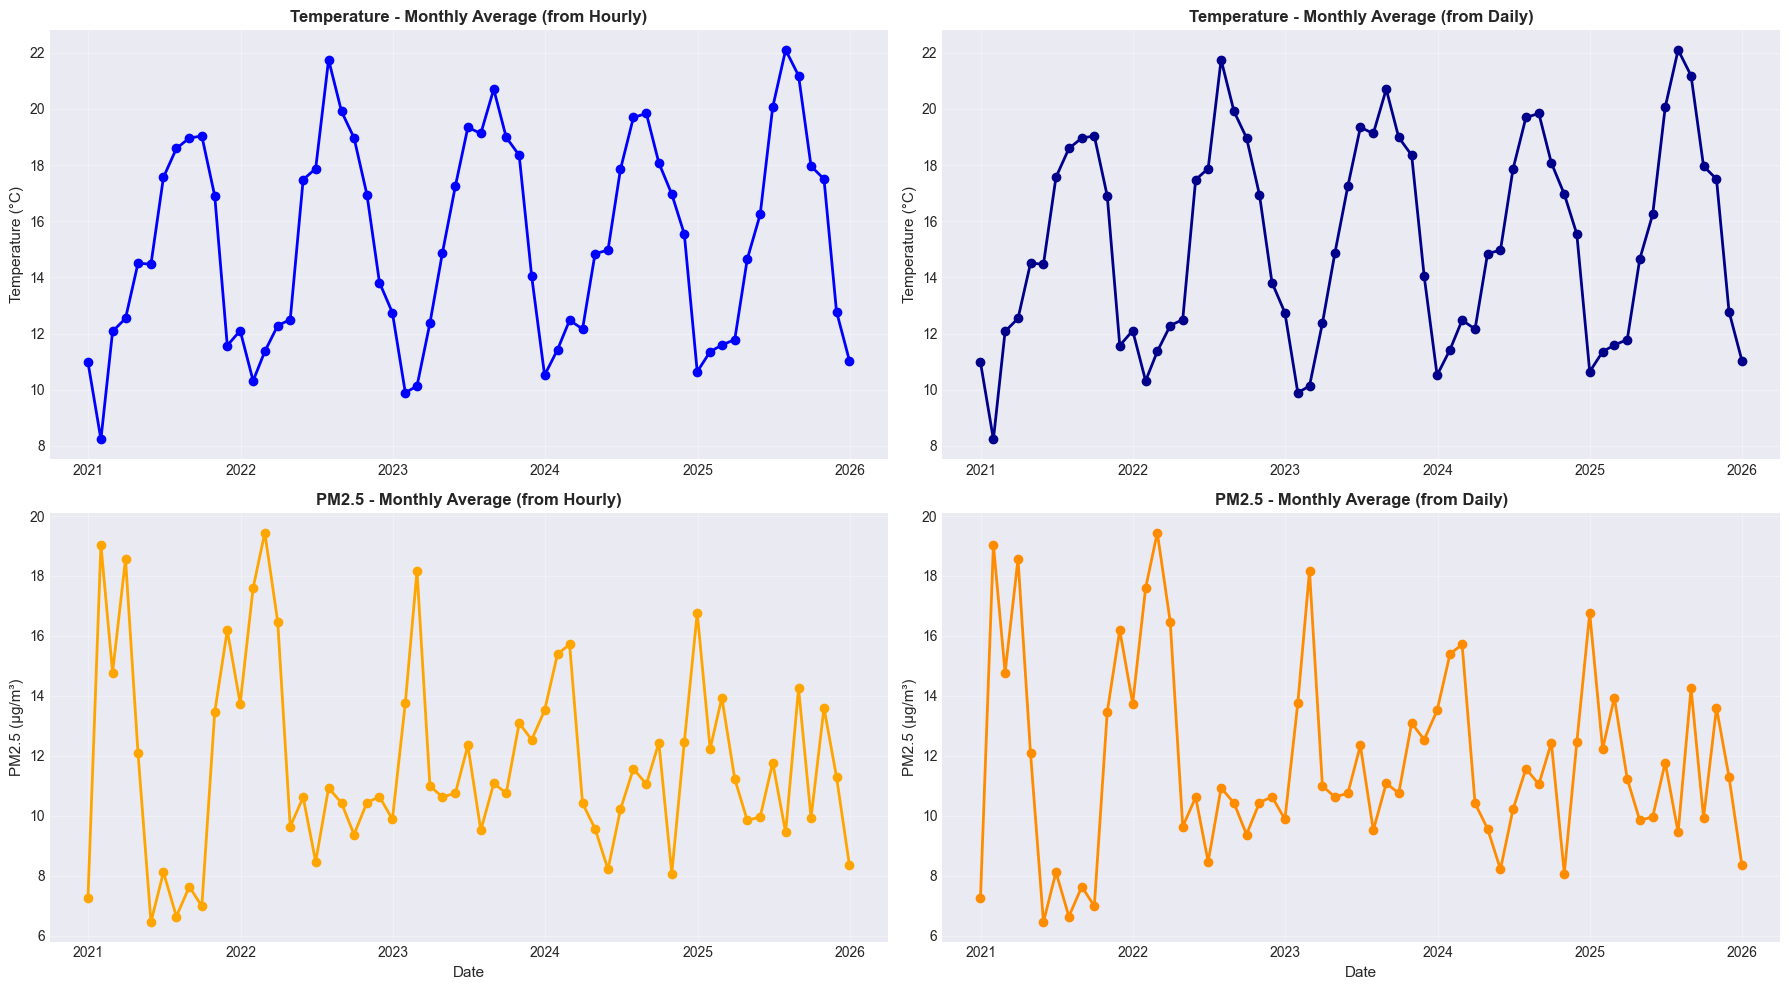

In [16]:
# Monthly averages
temp_monthly_h = temp_hourly.resample('M').mean()
temp_monthly_d = temp_daily.resample('M').mean()
pm25_monthly_h = pm25_hourly.resample('M').mean()
pm25_monthly_d = pm25_daily.resample('M').mean()

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Temperature - Hourly monthly
axes[0, 0].plot(temp_monthly_h.index, temp_monthly_h.values, marker='o', linewidth=2, color='blue')
axes[0, 0].set_title('Temperature - Monthly Average (from Hourly)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Temperature - Daily monthly
axes[0, 1].plot(temp_monthly_d.index, temp_monthly_d.values, marker='o', linewidth=2, color='darkblue')
axes[0, 1].set_title('Temperature - Monthly Average (from Daily)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# PM2.5 - Hourly monthly
axes[1, 0].plot(pm25_monthly_h.index, pm25_monthly_h.values, marker='o', linewidth=2, color='orange')
axes[1, 0].set_title('PM2.5 - Monthly Average (from Hourly)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# PM2.5 - Daily monthly
axes[1, 1].plot(pm25_monthly_d.index, pm25_monthly_d.values, marker='o', linewidth=2, color='darkorange')
axes[1, 1].set_title('PM2.5 - Monthly Average (from Daily)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 1].set_xlabel('Date', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

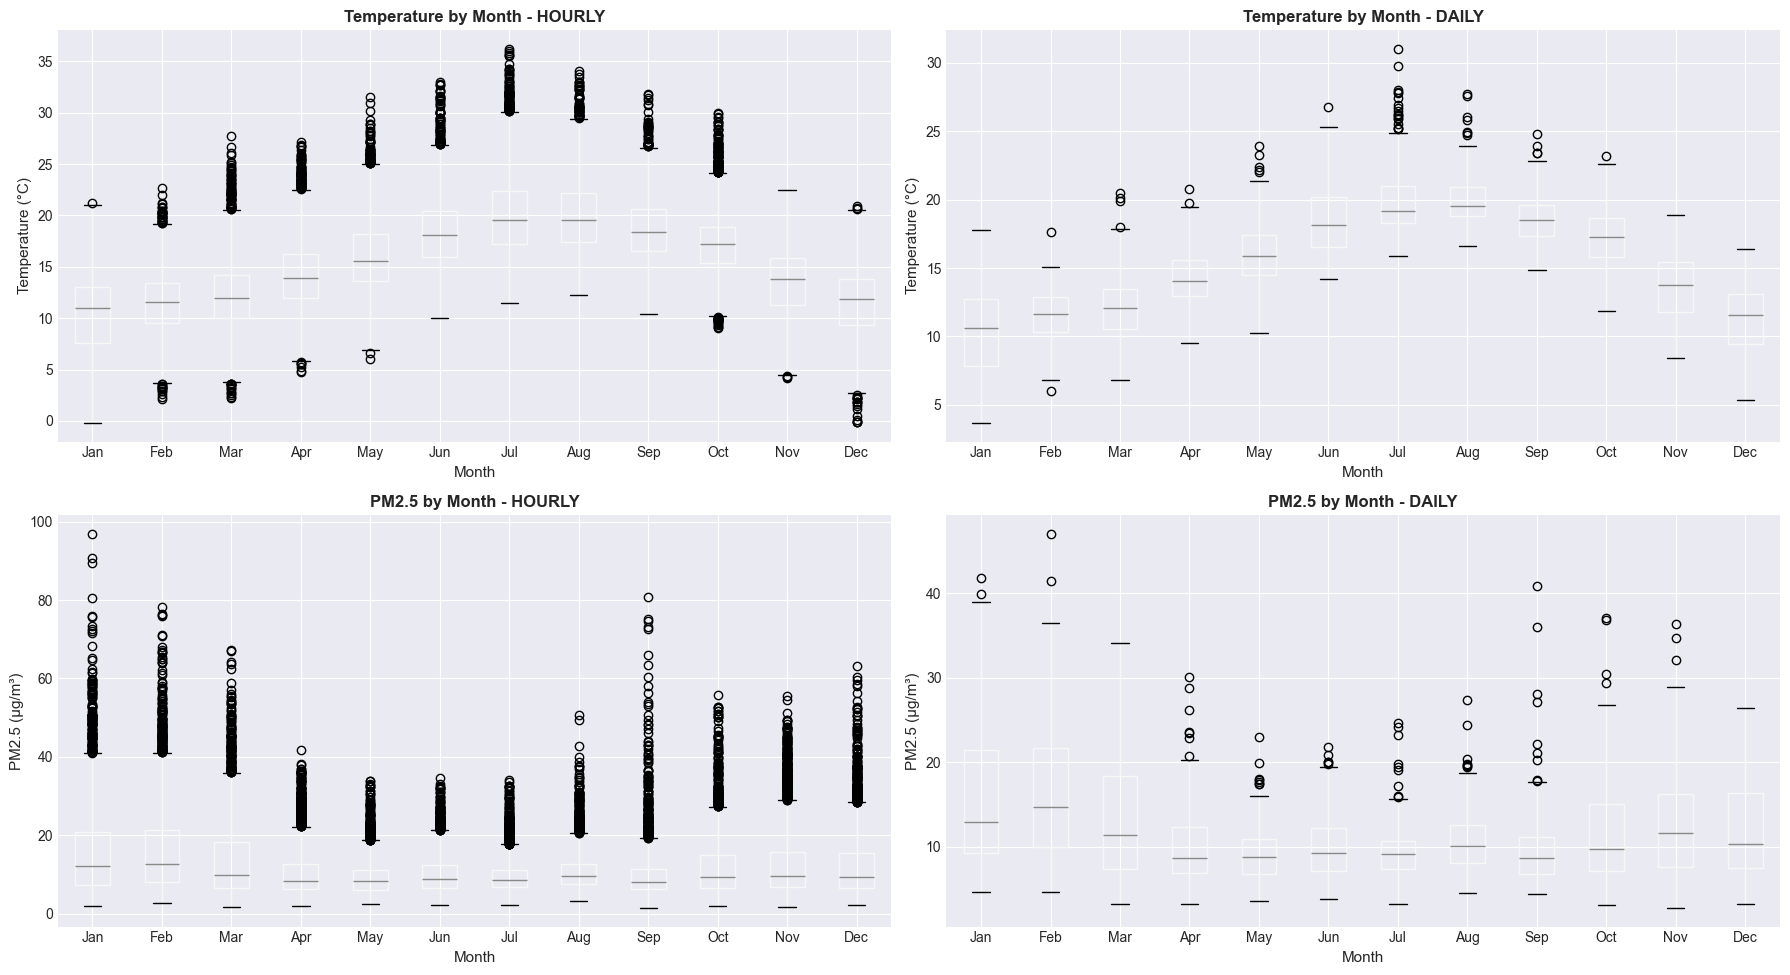

In [17]:
# Boxplot by month (aggregating across all years)
temp_h_df = pd.DataFrame({'value': temp_hourly.values, 'month': temp_hourly.index.month})
temp_d_df = pd.DataFrame({'value': temp_daily.values, 'month': temp_daily.index.month})
pm25_h_df = pd.DataFrame({'value': pm25_hourly.values, 'month': pm25_hourly.index.month})
pm25_d_df = pd.DataFrame({'value': pm25_daily.values, 'month': pm25_daily.index.month})

month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Temperature - Hourly by month
temp_h_df.boxplot(column='value', by='month', ax=axes[0, 0])
axes[0, 0].set_title('Temperature by Month - HOURLY', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Month', fontsize=11)
axes[0, 0].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 0].set_xticklabels(month_labels)
plt.sca(axes[0, 0])
plt.xticks(range(1, 13), month_labels)

# Temperature - Daily by month
temp_d_df.boxplot(column='value', by='month', ax=axes[0, 1])
axes[0, 1].set_title('Temperature by Month - DAILY', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month', fontsize=11)
axes[0, 1].set_ylabel('Temperature (°C)', fontsize=11)
axes[0, 1].set_xticklabels(month_labels)
plt.sca(axes[0, 1])
plt.xticks(range(1, 13), month_labels)

# PM2.5 - Hourly by month
pm25_h_df.boxplot(column='value', by='month', ax=axes[1, 0])
axes[1, 0].set_title('PM2.5 by Month - HOURLY', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 0].set_xticklabels(month_labels)
plt.sca(axes[1, 0])
plt.xticks(range(1, 13), month_labels)

# PM2.5 - Daily by month
pm25_d_df.boxplot(column='value', by='month', ax=axes[1, 1])
axes[1, 1].set_title('PM2.5 by Month - DAILY', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month', fontsize=11)
axes[1, 1].set_ylabel('PM2.5 (μg/m³)', fontsize=11)
axes[1, 1].set_xticklabels(month_labels)
plt.sca(axes[1, 1])
plt.xticks(range(1, 13), month_labels)

plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

### 5.2 Hourly Patterns (Daily Seasonality)

This only applies to hourly data

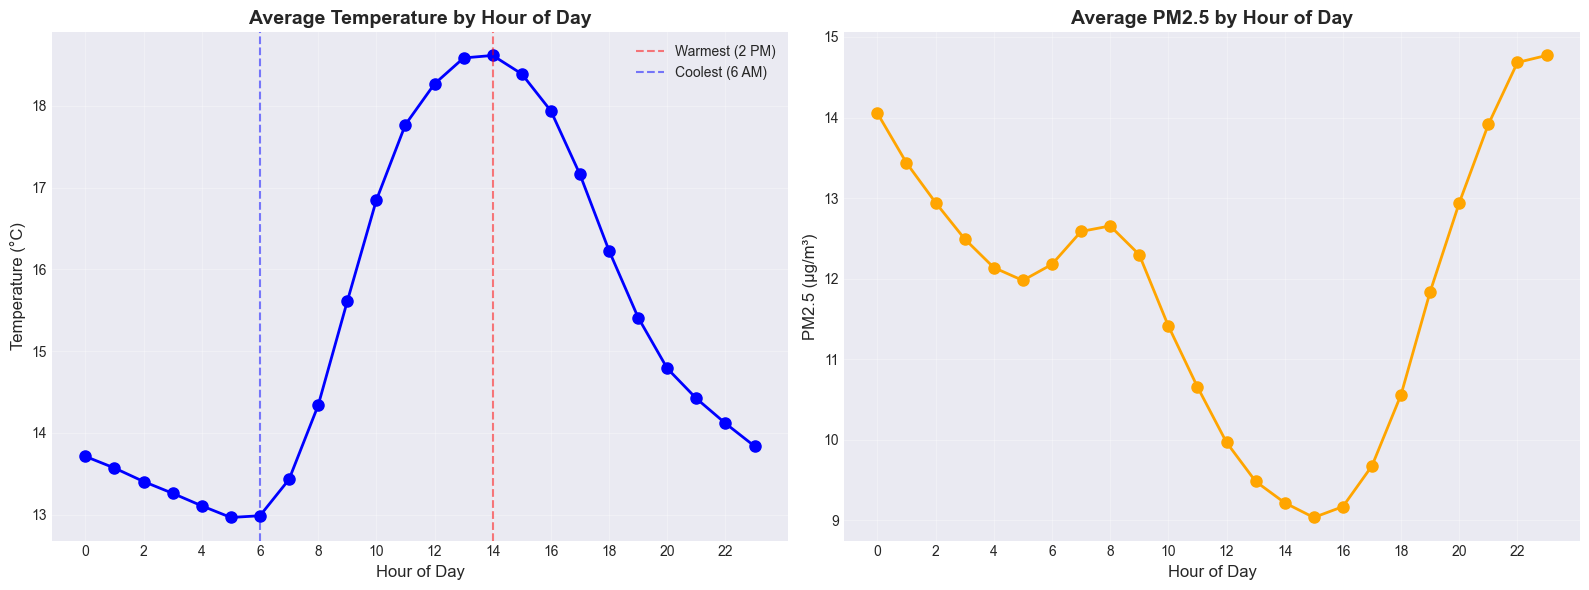

In [36]:
# Average by hour of day (only for hourly data)
temp_by_hour = temp_hourly.groupby(temp_hourly.index.hour).mean()
pm25_by_hour = pm25_hourly.groupby(pm25_hourly.index.hour).mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Temperature by hour
axes[0].plot(temp_by_hour.index, temp_by_hour.values, marker='o', linewidth=2, markersize=8, color='blue')
axes[0].set_title('Average Temperature by Hour of Day', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24, 2))
axes[0].axvline(x=14, color='red', linestyle='--', alpha=0.5, label='Warmest (2 PM)')
axes[0].axvline(x=6, color='blue', linestyle='--', alpha=0.5, label='Coolest (6 AM)')
axes[0].legend()

# PM2.5 by hour
axes[1].plot(pm25_by_hour.index, pm25_by_hour.values, marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_title('Average PM2.5 by Hour of Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.show()


## 6. Time Series Decomposition

Decompose into: Trend + Seasonal + Residual

- **Hourly**: Use period=24 (daily seasonality)
- **Daily**: Use period=365 (yearly seasonality)

Decomposing 1440 hours of HOURLY temperature data (period=24)...


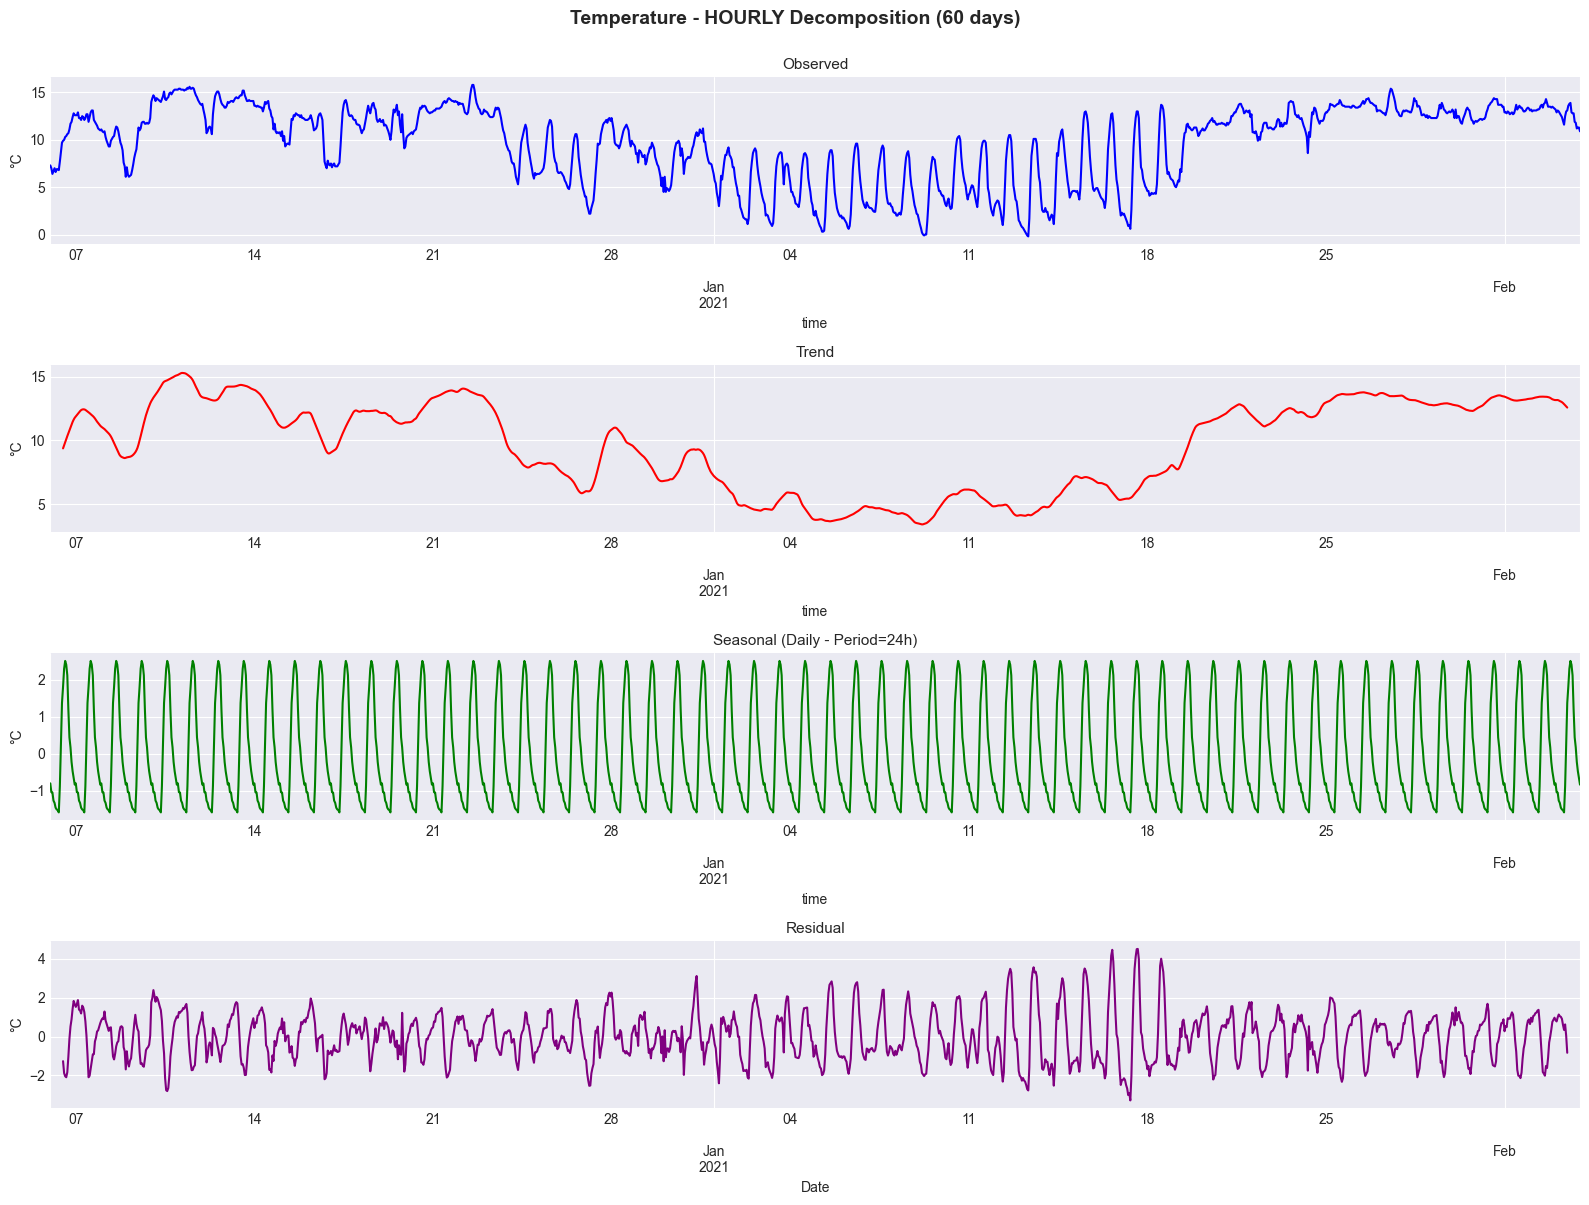

In [19]:
# HOURLY decomposition - Temperature (sample: 60 days)
sample_hours = 24 * 60  # 60 days
temp_h_sample = temp_hourly.iloc[:sample_hours]

print(f"Decomposing {sample_hours} hours of HOURLY temperature data (period=24)...")
decomp_temp_h = seasonal_decompose(temp_h_sample, model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomp_temp_h.observed.plot(ax=axes[0], color='blue')
axes[0].set_title('Observed', fontsize=11)
axes[0].set_ylabel('°C')

decomp_temp_h.trend.plot(ax=axes[1], color='red')
axes[1].set_title('Trend', fontsize=11)
axes[1].set_ylabel('°C')

decomp_temp_h.seasonal.plot(ax=axes[2], color='green')
axes[2].set_title('Seasonal (Daily - Period=24h)', fontsize=11)
axes[2].set_ylabel('°C')

decomp_temp_h.resid.plot(ax=axes[3], color='purple')
axes[3].set_title('Residual', fontsize=11)
axes[3].set_ylabel('°C')
axes[3].set_xlabel('Date')

plt.suptitle('Temperature - HOURLY Decomposition (60 days)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Decomposing 1826 days of DAILY temperature data (period=365)...


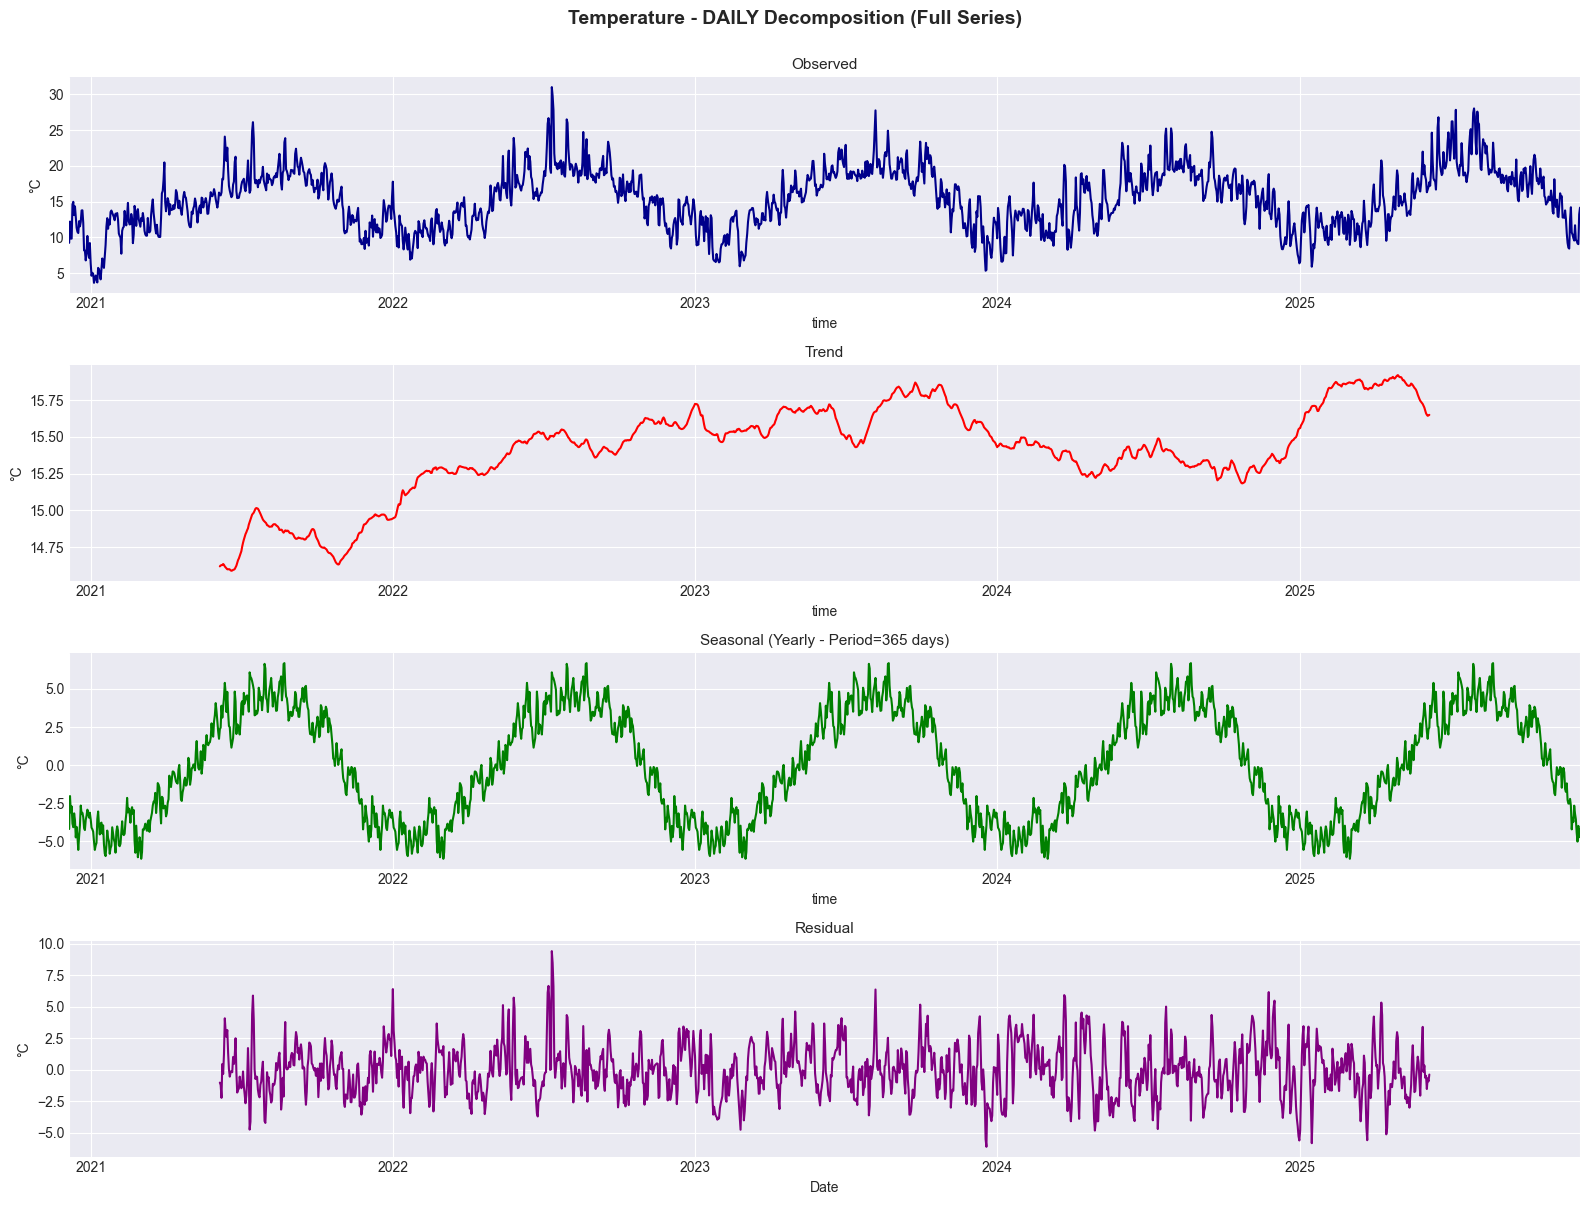

In [20]:
# DAILY decomposition - Temperature (full series)
print(f"Decomposing {len(temp_daily)} days of DAILY temperature data (period=365)...")
decomp_temp_d = seasonal_decompose(temp_daily, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomp_temp_d.observed.plot(ax=axes[0], color='darkblue')
axes[0].set_title('Observed', fontsize=11)
axes[0].set_ylabel('°C')

decomp_temp_d.trend.plot(ax=axes[1], color='red')
axes[1].set_title('Trend', fontsize=11)
axes[1].set_ylabel('°C')

decomp_temp_d.seasonal.plot(ax=axes[2], color='green')
axes[2].set_title('Seasonal (Yearly - Period=365 days)', fontsize=11)
axes[2].set_ylabel('°C')

decomp_temp_d.resid.plot(ax=axes[3], color='purple')
axes[3].set_title('Residual', fontsize=11)
axes[3].set_ylabel('°C')
axes[3].set_xlabel('Date')

plt.suptitle('Temperature - DAILY Decomposition (Full Series)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Decomposing 1440 hours of HOURLY PM2.5 data (period=24)...


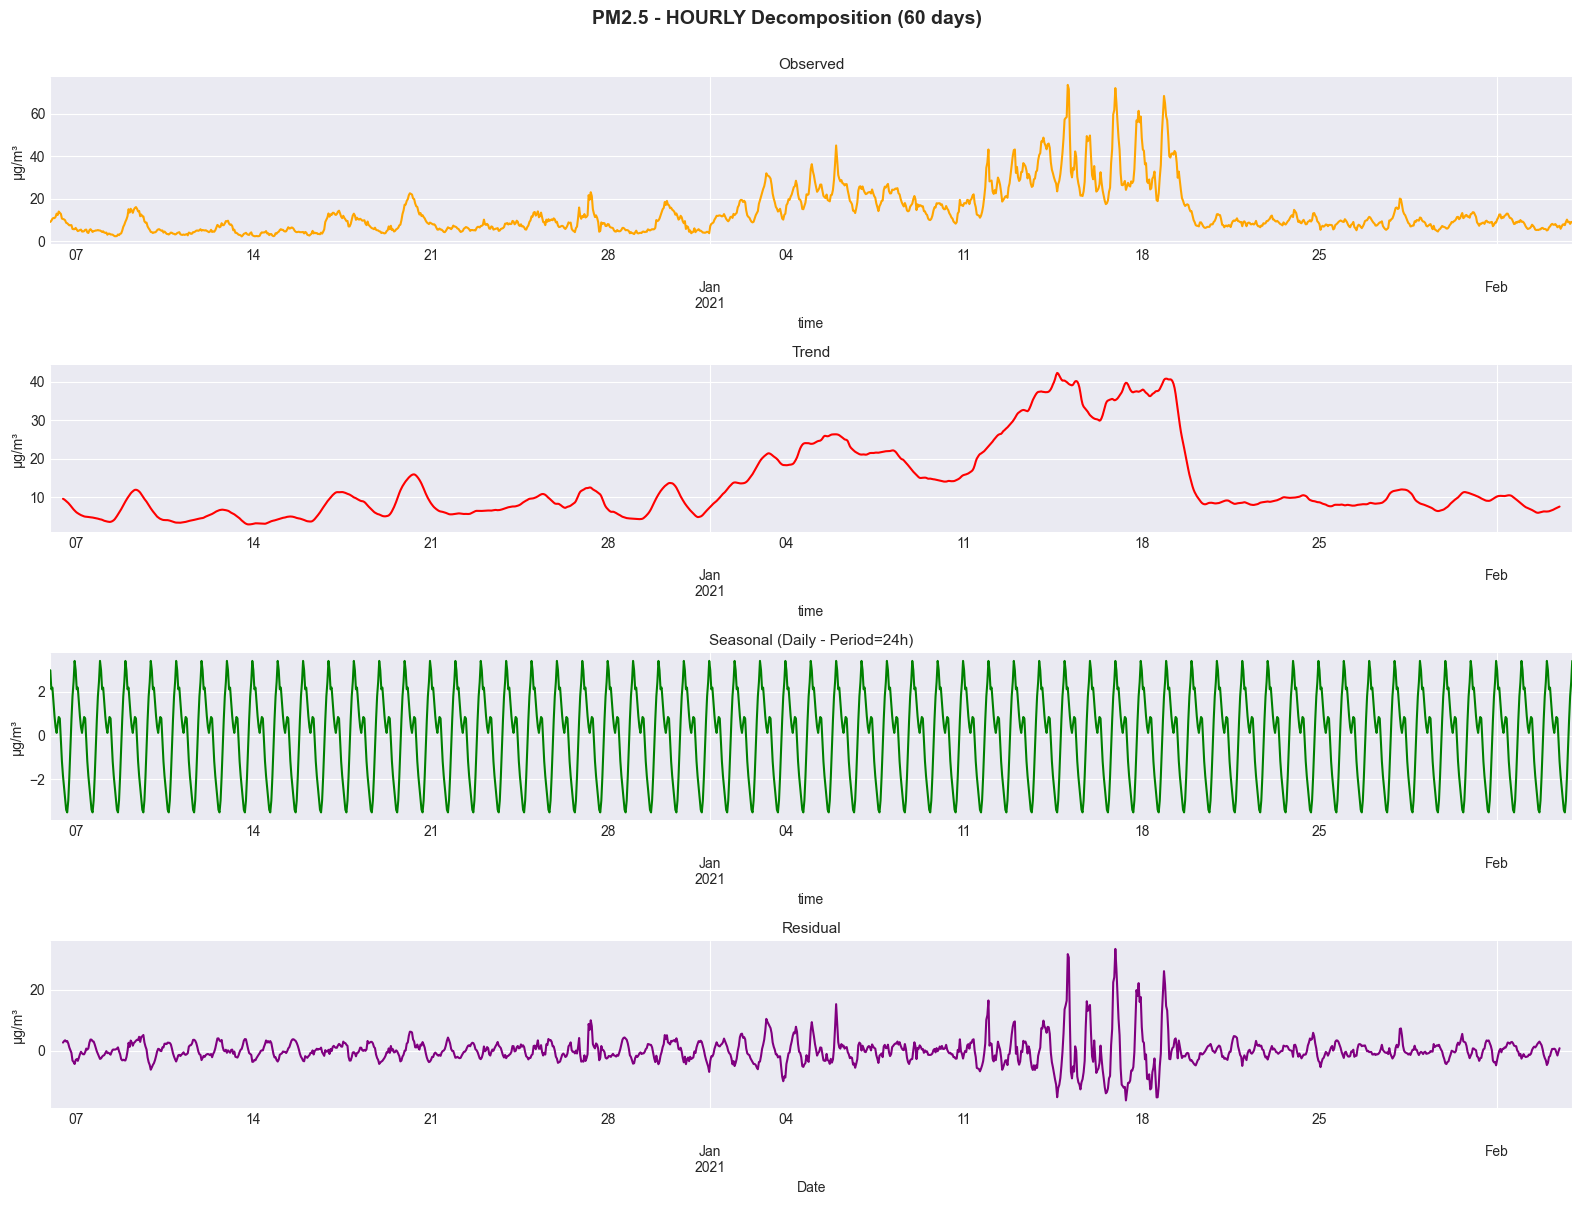

In [21]:
# HOURLY decomposition - PM2.5 (sample: 60 days)
pm25_h_sample = pm25_hourly.iloc[:sample_hours]

print(f"Decomposing {sample_hours} hours of HOURLY PM2.5 data (period=24)...")
decomp_pm25_h = seasonal_decompose(pm25_h_sample, model='additive', period=24)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomp_pm25_h.observed.plot(ax=axes[0], color='orange')
axes[0].set_title('Observed', fontsize=11)
axes[0].set_ylabel('μg/m³')

decomp_pm25_h.trend.plot(ax=axes[1], color='red')
axes[1].set_title('Trend', fontsize=11)
axes[1].set_ylabel('μg/m³')

decomp_pm25_h.seasonal.plot(ax=axes[2], color='green')
axes[2].set_title('Seasonal (Daily - Period=24h)', fontsize=11)
axes[2].set_ylabel('μg/m³')

decomp_pm25_h.resid.plot(ax=axes[3], color='purple')
axes[3].set_title('Residual', fontsize=11)
axes[3].set_ylabel('μg/m³')
axes[3].set_xlabel('Date')

plt.suptitle('PM2.5 - HOURLY Decomposition (60 days)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

Decomposing 1826 days of DAILY PM2.5 data (period=365)...


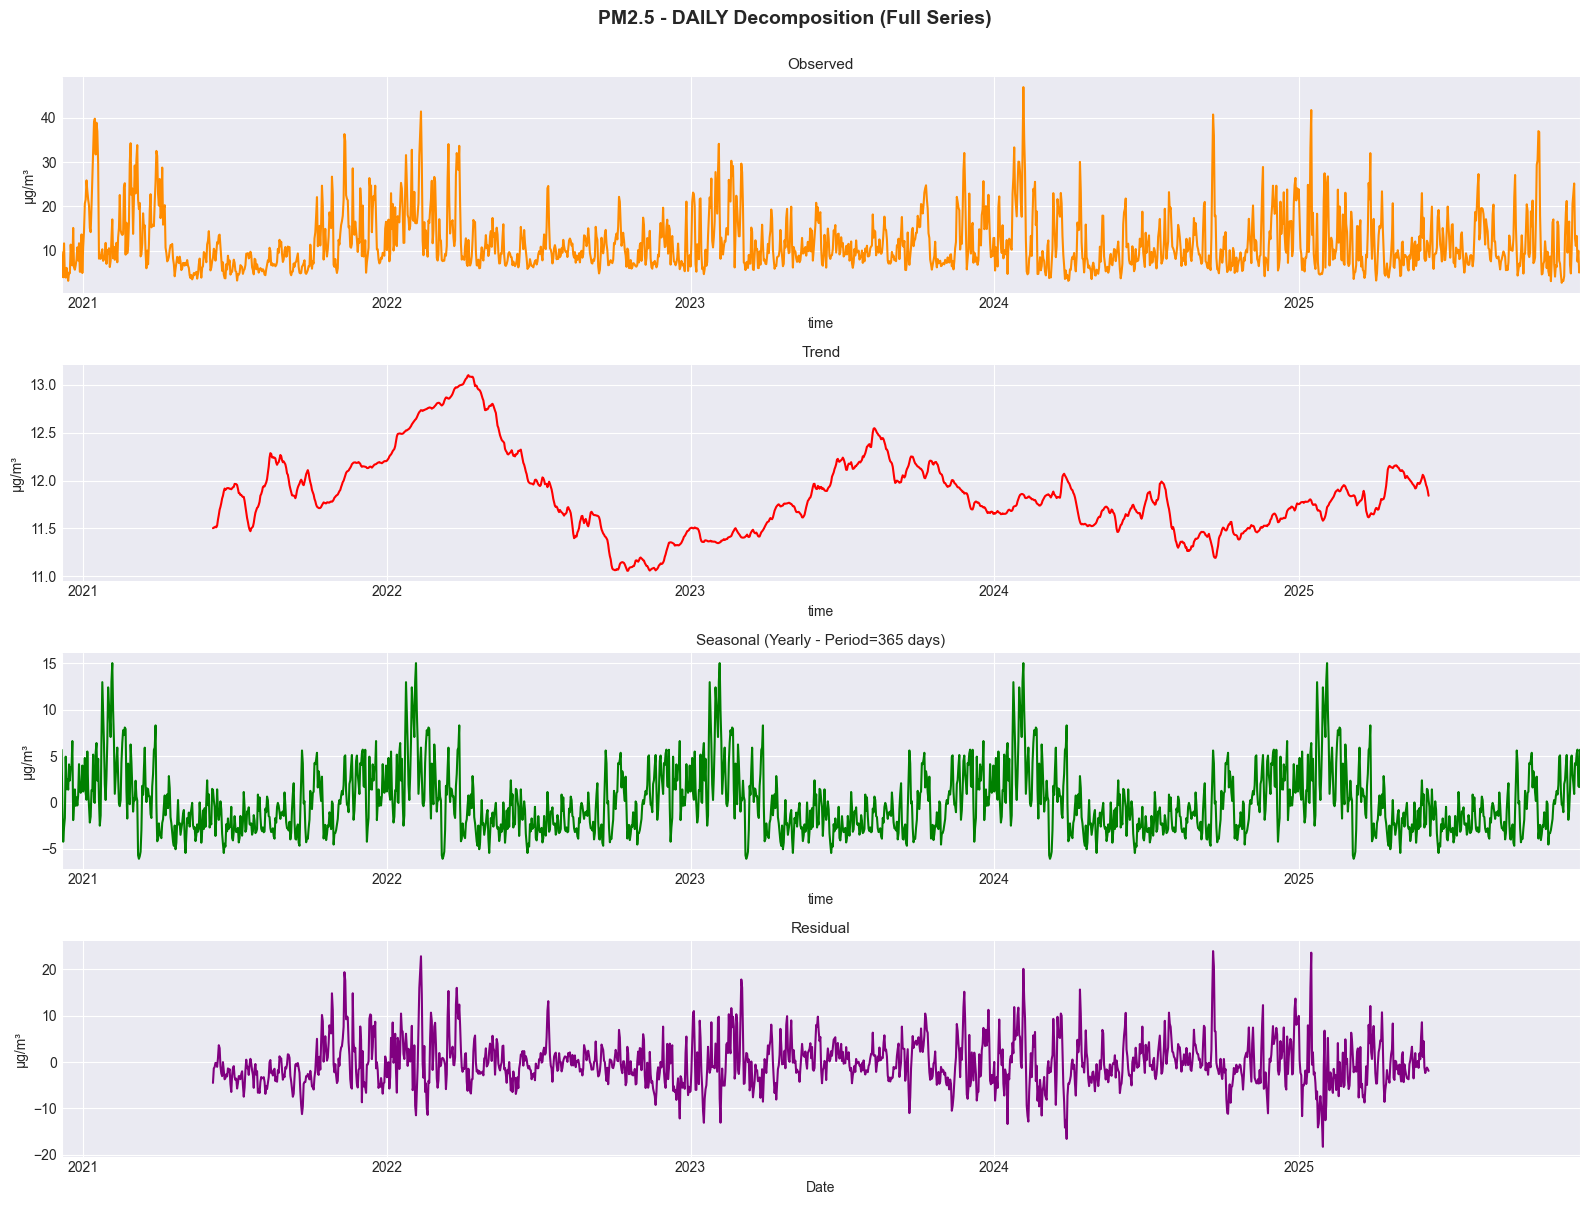

In [22]:
# DAILY decomposition - PM2.5 (full series)
print(f"Decomposing {len(pm25_daily)} days of DAILY PM2.5 data (period=365)...")
decomp_pm25_d = seasonal_decompose(pm25_daily, model='additive', period=365)

fig, axes = plt.subplots(4, 1, figsize=(16, 12))

decomp_pm25_d.observed.plot(ax=axes[0], color='darkorange')
axes[0].set_title('Observed', fontsize=11)
axes[0].set_ylabel('μg/m³')

decomp_pm25_d.trend.plot(ax=axes[1], color='red')
axes[1].set_title('Trend', fontsize=11)
axes[1].set_ylabel('μg/m³')

decomp_pm25_d.seasonal.plot(ax=axes[2], color='green')
axes[2].set_title('Seasonal (Yearly - Period=365 days)', fontsize=11)
axes[2].set_ylabel('μg/m³')

decomp_pm25_d.resid.plot(ax=axes[3], color='purple')
axes[3].set_title('Residual', fontsize=11)
axes[3].set_ylabel('μg/m³')
axes[3].set_xlabel('Date')

plt.suptitle('PM2.5 - DAILY Decomposition (Full Series)', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 7. Autocorrelation Analysis (ACF & PACF)

Critical for identifying ARIMA orders (p, d, q)

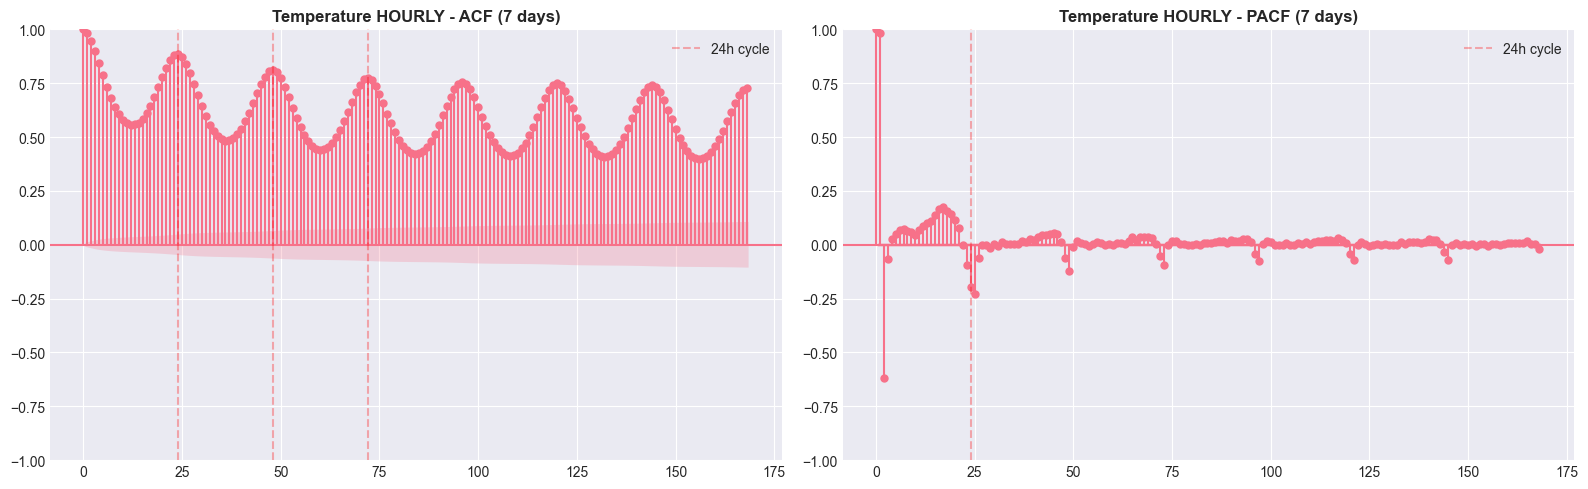

In [37]:
# Temperature - HOURLY ACF/PACF (showing 7 days = 168 lags)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(temp_hourly.dropna(), lags=168, ax=axes[0])
axes[0].set_title('Temperature HOURLY - ACF (7 days)', fontsize=12, fontweight='bold')
axes[0].axvline(x=24, color='red', linestyle='--', alpha=0.3, label='24h cycle')
axes[0].axvline(x=48, color='red', linestyle='--', alpha=0.3)
axes[0].axvline(x=72, color='red', linestyle='--', alpha=0.3)
axes[0].legend()

plot_pacf(temp_hourly.dropna(), lags=168, ax=axes[1])
axes[1].set_title('Temperature HOURLY - PACF (7 days)', fontsize=12, fontweight='bold')
axes[1].axvline(x=24, color='red', linestyle='--', alpha=0.3, label='24h cycle')
axes[1].legend()

plt.tight_layout()
plt.show()


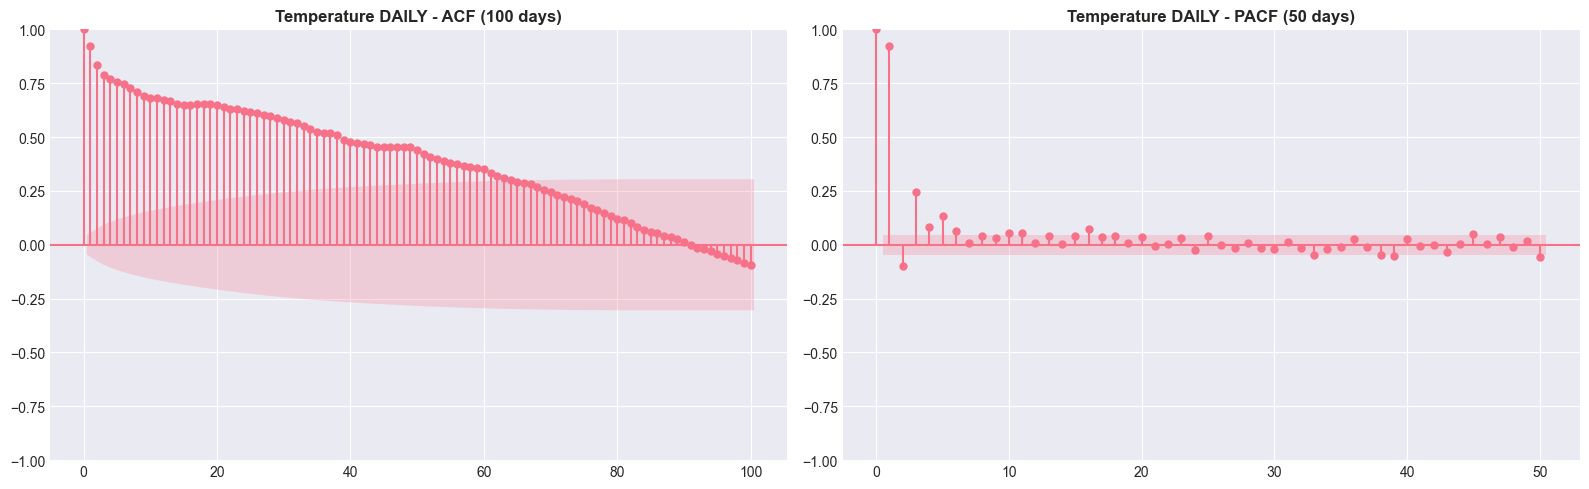

Note: Slow decay in ACF suggests non-stationarity (need differencing)


In [24]:
# Temperature - DAILY ACF/PACF (showing ~100 days)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(temp_daily.dropna(), lags=100, ax=axes[0])
axes[0].set_title('Temperature DAILY - ACF (100 days)', fontsize=12, fontweight='bold')

plot_pacf(temp_daily.dropna(), lags=50, ax=axes[1])
axes[1].set_title('Temperature DAILY - PACF (50 days)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Note: Slow decay in ACF suggests non-stationarity (need differencing)")

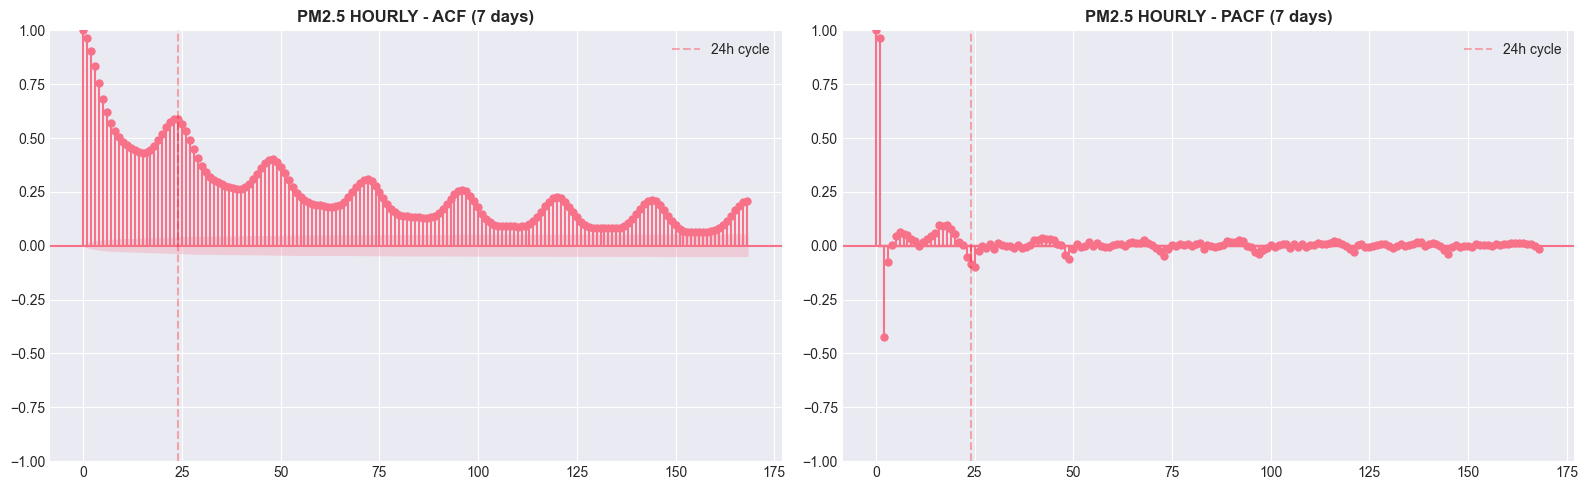

In [25]:
# PM2.5 - HOURLY ACF/PACF (showing 7 days = 168 lags)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(pm25_hourly.dropna(), lags=168, ax=axes[0])
axes[0].set_title('PM2.5 HOURLY - ACF (7 days)', fontsize=12, fontweight='bold')
axes[0].axvline(x=24, color='red', linestyle='--', alpha=0.3, label='24h cycle')
axes[0].legend()

plot_pacf(pm25_hourly.dropna(), lags=168, ax=axes[1])
axes[1].set_title('PM2.5 HOURLY - PACF (7 days)', fontsize=12, fontweight='bold')
axes[1].axvline(x=24, color='red', linestyle='--', alpha=0.3, label='24h cycle')
axes[1].legend()

plt.tight_layout()
plt.show()

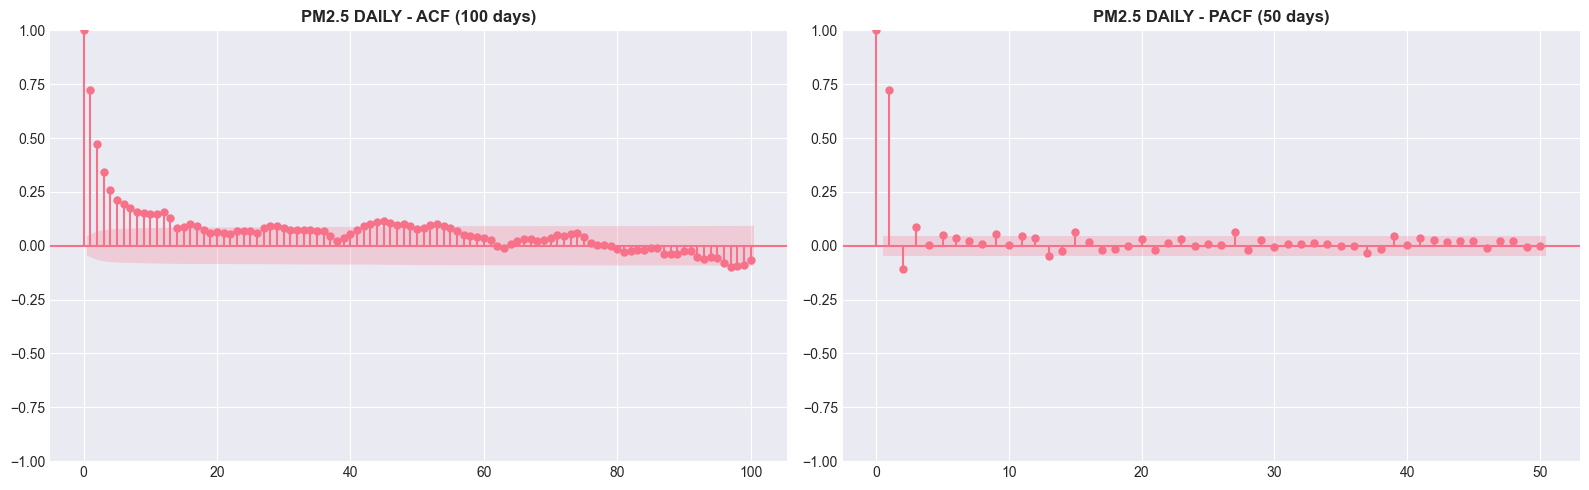

In [26]:
# PM2.5 - DAILY ACF/PACF (showing ~100 days)
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

plot_acf(pm25_daily.dropna(), lags=100, ax=axes[0])
axes[0].set_title('PM2.5 DAILY - ACF (100 days)', fontsize=12, fontweight='bold')

plot_pacf(pm25_daily.dropna(), lags=50, ax=axes[1])
axes[1].set_title('PM2.5 DAILY - PACF (50 days)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Stationarity Tests

**Critical for ARIMA modeling!**

We'll use:
- **ADF (Augmented Dickey-Fuller)**: H0 = non-stationary
- **KPSS**: H0 = stationary

In [27]:
def test_stationarity(series, name):
    """
    Perform ADF and KPSS tests for stationarity
    """
    print(f"\n{'='*70}")
    print(f"Stationarity Tests for {name}")
    print(f"{'='*70}\n")
    
    # ADF Test (H0: non-stationary)
    print("1. Augmented Dickey-Fuller (ADF) Test:")
    print("   H0: Series is NON-STATIONARY")
    adf_result = adfuller(series.dropna(), autolag='AIC')
    print(f"   ADF Statistic: {adf_result[0]:.6f}")
    print(f"   p-value: {adf_result[1]:.6f}")
    print(f"   Critical Values:")
    for key, value in adf_result[4].items():
        print(f"     {key}: {value:.6f}")
    
    if adf_result[1] < 0.05:
        print("   → REJECT H0: Series is STATIONARY (p < 0.05) ✓")
    else:
        print("   → FAIL TO REJECT H0: Series is NON-STATIONARY (p ≥ 0.05) ✗")
    
    # KPSS Test (H0: stationary)
    print("\n2. KPSS Test:")
    print("   H0: Series is STATIONARY")
    kpss_result = kpss(series.dropna(), regression='ct', nlags='auto')
    print(f"   KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"   p-value: {kpss_result[1]:.6f}")
    print(f"   Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"     {key}: {value:.6f}")
    
    if kpss_result[1] > 0.05:
        print("   → FAIL TO REJECT H0: Series is STATIONARY (p > 0.05) ✓")
    else:
        print("   → REJECT H0: Series is NON-STATIONARY (p ≤ 0.05) ✗")
    
    print(f"\n{'='*70}")

In [28]:
# Test HOURLY data
print("\n" + "#"*70)
print("TESTING HOURLY DATA")
print("#"*70)

test_stationarity(temp_hourly, "Temperature (Hourly)")
test_stationarity(pm25_hourly, "PM2.5 (Hourly)")


######################################################################
TESTING HOURLY DATA
######################################################################

Stationarity Tests for Temperature (Hourly)

1. Augmented Dickey-Fuller (ADF) Test:
   H0: Series is NON-STATIONARY
   ADF Statistic: -8.854507
   p-value: 0.000000
   Critical Values:
     1%: -3.430499
     5%: -2.861606
     10%: -2.566805
   → REJECT H0: Series is STATIONARY (p < 0.05) ✓

2. KPSS Test:
   H0: Series is STATIONARY
   KPSS Statistic: 0.422062
   p-value: 0.010000
   Critical Values:
     10%: 0.119000
     5%: 0.146000
     2.5%: 0.176000
     1%: 0.216000
   → REJECT H0: Series is NON-STATIONARY (p ≤ 0.05) ✗


Stationarity Tests for PM2.5 (Hourly)

1. Augmented Dickey-Fuller (ADF) Test:
   H0: Series is NON-STATIONARY
   ADF Statistic: -16.463199
   p-value: 0.000000
   Critical Values:
     1%: -3.430499
     5%: -2.861606
     10%: -2.566805
   → REJECT H0: Series is STATIONARY (p < 0.05) ✓

2. KPSS Tes

In [29]:
# Test DAILY data
print("\n" + "#"*70)
print("TESTING DAILY DATA")
print("#"*70)

test_stationarity(temp_daily, "Temperature (Daily)")
test_stationarity(pm25_daily, "PM2.5 (Daily)")


######################################################################
TESTING DAILY DATA
######################################################################

Stationarity Tests for Temperature (Daily)

1. Augmented Dickey-Fuller (ADF) Test:
   H0: Series is NON-STATIONARY
   ADF Statistic: -3.036944
   p-value: 0.031585
   Critical Values:
     1%: -3.433972
     5%: -2.863140
     10%: -2.567622
   → REJECT H0: Series is STATIONARY (p < 0.05) ✓

2. KPSS Test:
   H0: Series is STATIONARY
   KPSS Statistic: 0.089536
   p-value: 0.100000
   Critical Values:
     10%: 0.119000
     5%: 0.146000
     2.5%: 0.176000
     1%: 0.216000
   → FAIL TO REJECT H0: Series is STATIONARY (p > 0.05) ✓


Stationarity Tests for PM2.5 (Daily)

1. Augmented Dickey-Fuller (ADF) Test:
   H0: Series is NON-STATIONARY
   ADF Statistic: -7.924496
   p-value: 0.000000
   Critical Values:
     1%: -3.433966
     5%: -2.863137
     10%: -2.567620
   → REJECT H0: Series is STATIONARY (p < 0.05) ✓

2. KPSS Tes

### Interpretation of Stationarity Results

**Key Insight:** The stationarity tests reveal important characteristics about both time scales that will guide our modeling approach.

---

#### HOURLY DATA:

**Temperature (Hourly):**
- ADF Test: p = 0.000 → STATIONARY ✓
- KPSS Test: p = 0.01 → NON-STATIONARY ✗
- **Interpretation:** Conflicting results suggest **trend stationarity but seasonal non-stationarity**
- Strong daily mean reversion (temperature cycles up/down every 24 hours)
- However, underlying seasonal patterns (yearly) remain

**PM2.5 (Hourly):**
- ADF Test: p = 0.000 → STATIONARY ✓
- KPSS Test: p = 0.10 → STATIONARY ✓
- **Interpretation:** Both tests agree - appears stationary at the hourly scale
- Daily cycles provide mean reversion
- Less pronounced seasonal patterns than temperature

---

#### DAILY DATA:

**Temperature (Daily):**
- ADF Test: p = 0.032 → STATIONARY ✓
- KPSS Test: p = 0.10 → STATIONARY ✓
- **Interpretation:** Both tests agree - **no unit root or deterministic trend**
- This suggests Porto's temperature has been stable over the 5-year period
- **However:** Clear seasonal patterns visible in plots (summer vs winter)
- This is **"deterministic seasonality"** - predictable cycles without trend

**PM2.5 (Daily):**
- ADF Test: p = 0.000 → STATIONARY ✓
- KPSS Test: p = 0.10 → STATIONARY ✓
- **Interpretation:** Both tests agree - stationary
- No significant trend over the 5-year period
- Still exhibits seasonal variations that need modeling

---

#### Critical Understanding:

**"Stationary" ≠ "No Seasonal Patterns"**

The ADF/KPSS tests check for:
- **Unit roots** (random walk behavior)
- **Deterministic trends** (steady increase/decrease)

They do NOT test for:
- **Seasonal patterns** (repeating cycles)
- **Deterministic seasonality** (predictable summer/winter variations)

Our data shows:
- ✓ No unit root (not a random walk)
- ✓ No long-term trend (stable over 5 years)
- ✗ BUT strong seasonal patterns exist (visible in decomposition plots)

## 9. Correlation Between Variables

Correlation between Temperature and PM2.5:
  Hourly: -0.2362
  Daily:  -0.2055


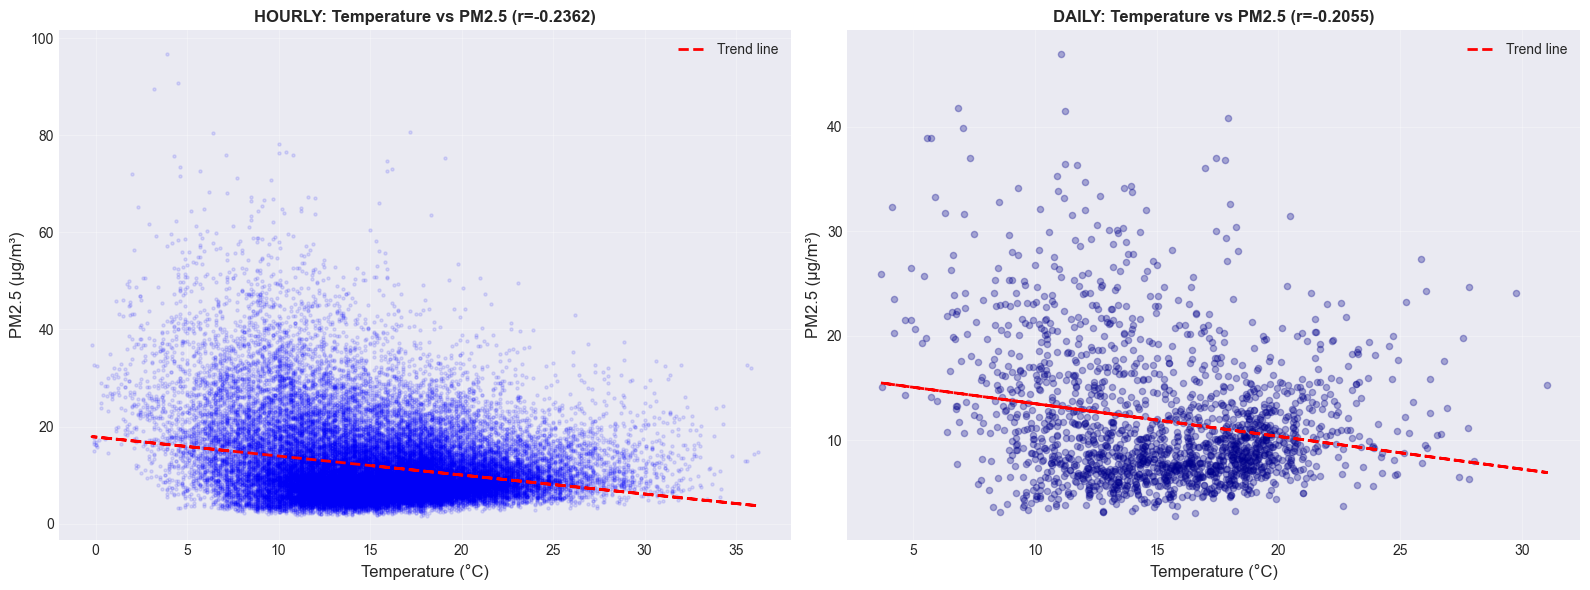

In [30]:
# Correlation analysis
corr_hourly = temp_hourly.corr(pm25_hourly)
corr_daily = temp_daily.corr(pm25_daily)

print(f"Correlation between Temperature and PM2.5:")
print(f"  Hourly: {corr_hourly:.4f}")
print(f"  Daily:  {corr_daily:.4f}")

# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Hourly
axes[0].scatter(temp_hourly, pm25_hourly, alpha=0.1, s=5, color='blue')
z = np.polyfit(temp_hourly, pm25_hourly, 1)
p = np.poly1d(z)
axes[0].plot(temp_hourly, p(temp_hourly), "r--", linewidth=2, label='Trend line')
axes[0].set_xlabel('Temperature (°C)', fontsize=12)
axes[0].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
axes[0].set_title(f'HOURLY: Temperature vs PM2.5 (r={corr_hourly:.4f})', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Daily
axes[1].scatter(temp_daily, pm25_daily, alpha=0.3, s=20, color='darkblue')
z = np.polyfit(temp_daily, pm25_daily, 1)
p = np.poly1d(z)
axes[1].plot(temp_daily, p(temp_daily), "r--", linewidth=2, label='Trend line')
axes[1].set_xlabel('Temperature (°C)', fontsize=12)
axes[1].set_ylabel('PM2.5 (μg/m³)', fontsize=12)
axes[1].set_title(f'DAILY: Temperature vs PM2.5 (r={corr_daily:.4f})', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 10. Summary of Key Findings

In [39]:
print("="*80)
print("SUMMARY OF KEY FINDINGS")
print("="*80)

print("\n DATA OVERVIEW:")
print(f"  Hourly data:  {len(temp_hourly):>6,} observations over {len(temp_hourly)/(24*365):.2f} years")
print(f"  Daily data:   {len(temp_daily):>6,} observations over {len(temp_daily)/365:.2f} years")

print("\n  TEMPERATURE:")
print(f"  Range (Hourly): {temp_hourly.min():.2f}°C to {temp_hourly.max():.2f}°C")
print(f"  Mean (Hourly):  {temp_hourly.mean():.2f}°C (Std: {temp_hourly.std():.2f}°C)")
print(f"  Range (Daily):  {temp_daily.min():.2f}°C to {temp_daily.max():.2f}°C")
print(f"  Mean (Daily):   {temp_daily.mean():.2f}°C (Std: {temp_daily.std():.2f}°C)")
print(f"  Seasonality:    Strong yearly cycle (summer/winter) + daily cycle (hourly)")
print(f"  Stationarity:   Hourly has conflicting tests (trend-stationary), Daily is stationary")

print("\n PM2.5:")
print(f"  Range (Hourly): {pm25_hourly.min():.2f} to {pm25_hourly.max():.2f} μg/m³")
print(f"  Mean (Hourly):  {pm25_hourly.mean():.2f} μg/m³ (Std: {pm25_hourly.std():.2f})")
print(f"  Range (Daily):  {pm25_daily.min():.2f} to {pm25_daily.max():.2f} μg/m³")
print(f"  Mean (Daily):   {pm25_daily.mean():.2f} μg/m³ (Std: {pm25_daily.std():.2f})")
print(f"  Seasonality:    Less pronounced than temperature")
print(f"  Stationarity:   Both hourly and daily are stationary (ADF & KPSS agree)")

print("\n CORRELATION:")
print(f"  Temperature vs PM2.5 (Hourly): {corr_hourly:>7.4f}")
print(f"  Temperature vs PM2.5 (Daily):  {corr_daily:>7.4f}")
print(f"  Interpretation: Weak negative correlation (warmer = slightly less PM2.5)")


print("\n" + "="*80)

SUMMARY OF KEY FINDINGS

 DATA OVERVIEW:
  Hourly data:  43,824 observations over 5.00 years
  Daily data:    1,826 observations over 5.00 years

  TEMPERATURE:
  Range (Hourly): -0.20°C to 36.20°C
  Mean (Hourly):  15.36°C (Std: 4.86°C)
  Range (Daily):  3.67°C to 31.01°C
  Mean (Daily):   15.36°C (Std: 4.19°C)
  Seasonality:    Strong yearly cycle (summer/winter) + daily cycle (hourly)
  Stationarity:   Hourly has conflicting tests (trend-stationary), Daily is stationary

 PM2.5:
  Range (Hourly): 1.50 to 96.80 μg/m³
  Mean (Hourly):  11.84 μg/m³ (Std: 8.05)
  Range (Daily):  2.74 to 46.97 μg/m³
  Mean (Daily):   11.84 μg/m³ (Std: 6.39)
  Seasonality:    Less pronounced than temperature
  Stationarity:   Both hourly and daily are stationary (ADF & KPSS agree)

 CORRELATION:
  Temperature vs PM2.5 (Hourly): -0.2362
  Temperature vs PM2.5 (Daily):  -0.2055
  Interpretation: Weak negative correlation (warmer = slightly less PM2.5)

